# Reinforcement Learning with Wikipedia Racing Agent

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JudgmentLabs/judgment-cookbook/blob/main/rl/WikiRacingAgent_RL.ipynb)
[![Docs](https://img.shields.io/badge/Documentation-blue)](https://docs.judgmentlabs.ai/documentation)

In this notebook, you will be using judgeval together with Fireworks AI to train your own Wikiracer agent from scratch! This guide shows how to integrate judgeval's multi-turn RL training module with a Python agent, using just a few lines of instrumentation on top of the base agent.

Beginning with a Qwen 2.5 7B base model, you will train the agent to play Wikiracer, a game where you have to traverse from one Wikipedia page to another as fast as possible. For example, you may have to get from the Virus page to the European Commission page by clicking on Dmitri Ivanovsky to Poland and so on.

You will instrument a simple agent environment, reward function, and existing Wikiracing agent code with Judgeval's RL training module. The trainer will route to Fireworks' RFT endpoint to execute a hosted training loop so you don't have to orchestrate data pipelines or manage compute infrastructure!






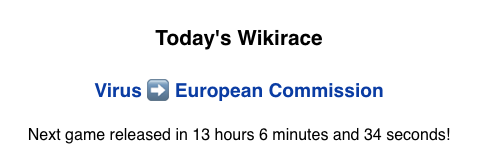

This notebook will use the ```judgeval``` library, specifically the ```judgeval.trainer```, ```judgeval.tracer```, and ```judgeval.scorers```   



To run this notebook and train a WikiRacer Agent, select **Runtime* -> Run All*

In [ ]:
# Install and Import Dependencies
!pip install wikipedia requests openai python-dotenv judgeval
!pip install --upgrade fireworks-ai




# Setup

Judgment Labs helps users monitor and evaluate agents in production. We use some of the infrastructure created by Judgment Labs in this notebook to demonstrate this functionality on the Wikiracer agent we will create.

You can get your Judgment API key and Org ID for free on the [Judgment Labs Platform](https://app.judgmentlabs.ai/register)
```
JUDGMENT API_KEY, JUDGMENT_ORG_ID
```



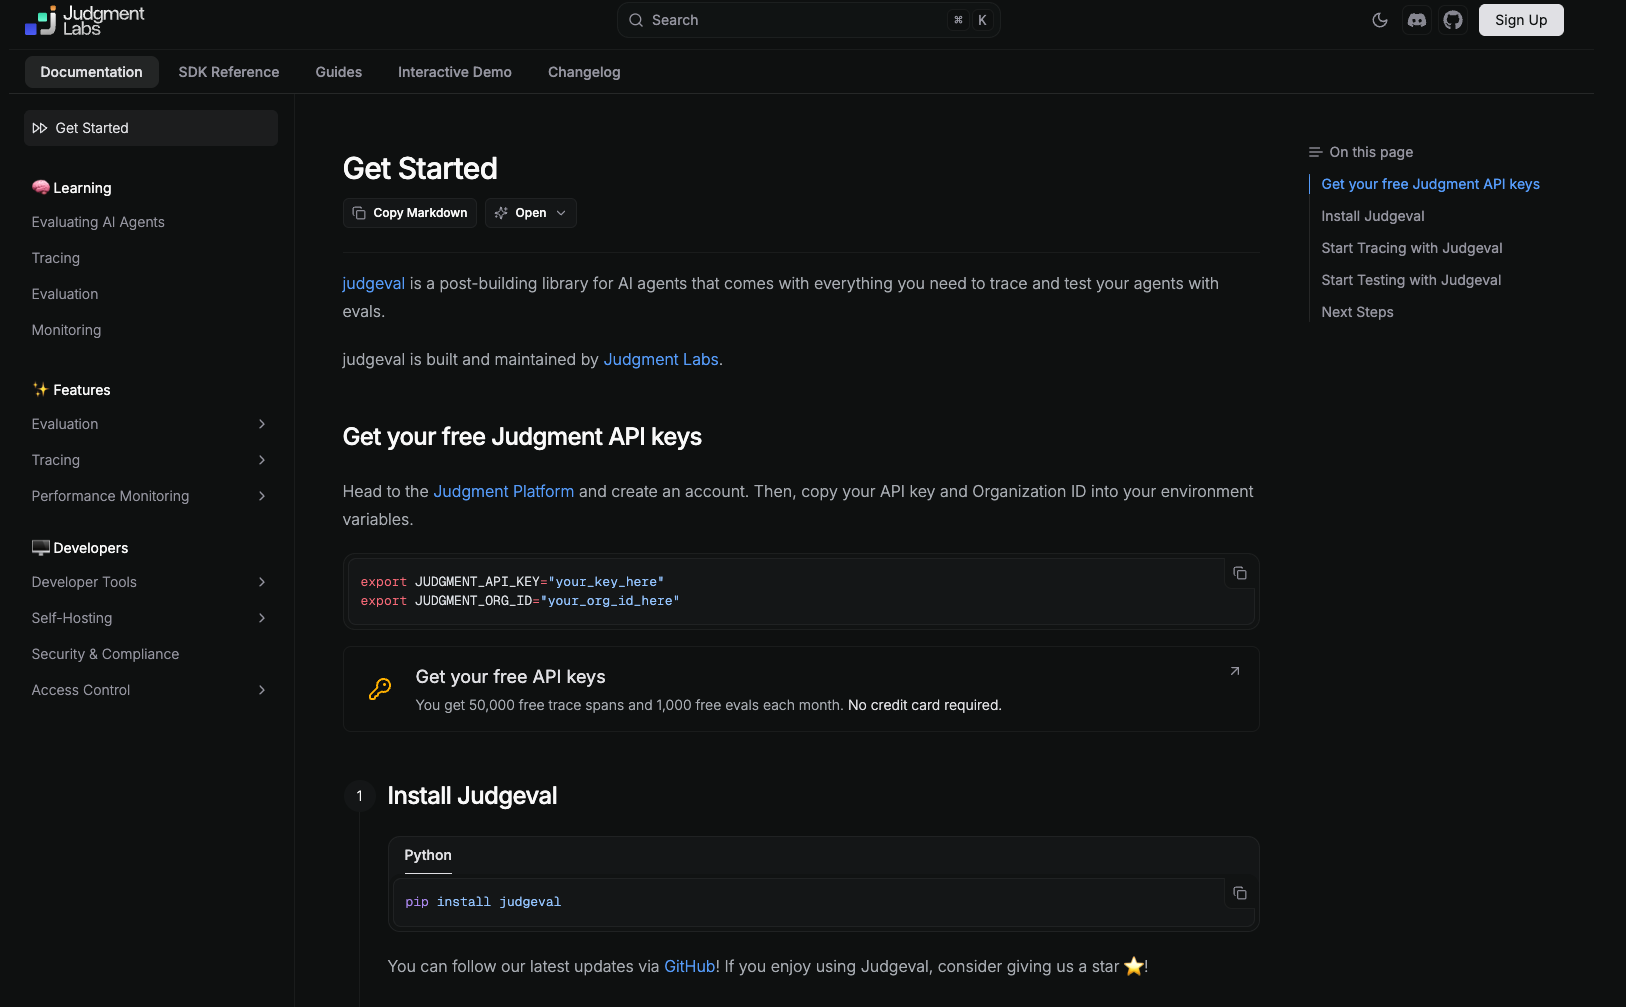

Create a project titled ```wikipeda-tracing-agent``` in your organization

# Fireworks Integration
One of the most important aspects of this notebook is to demonstrate the integration between Judgment Labs and the Fireworks RFT layer. In order to run this integration, you will need a Fireworks [account](https://fireworks.ai/models/fireworks/gpt-oss-120b?utm_term=try%20gpt%20oss&utm_campaign=Model+Ads&utm_source=adwords&utm_medium=ppc&hsa_acc=6824341280&hsa_cam=22178032006&hsa_grp=184596082952&hsa_ad=769836452118&hsa_src=g&hsa_tgt=kwd-2435895313574&hsa_kw=try%20gpt%20oss&hsa_mt=b&hsa_net=adwords&hsa_ver=3&gad_source=1&gad_campaignid=22178032006&gbraid=0AAAAA-vkpDMNFYpW82VA1cwxkZqpL6xBA&gclid=Cj0KCQjwuKnGBhD5ARIsAD19RsZlJ6gcEhusZsBx4nmkjZzFqXPbS16c1ZX8kaGqVU6DXQ_jBd3U5AwaAsWCEALw_wcB) and a `FIREWORKS_API_KEY`

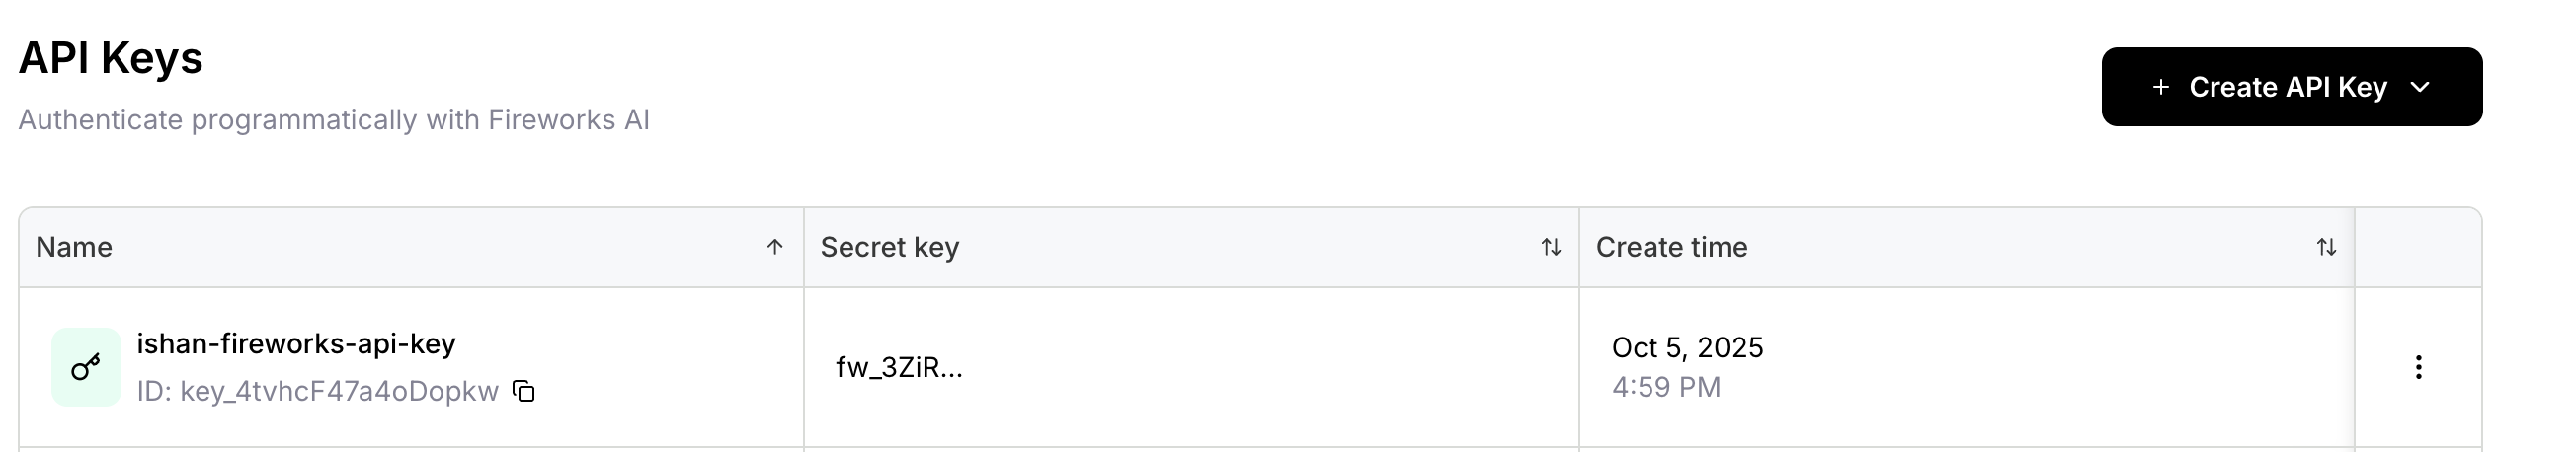
### About Fireworks
Fireworks allows users to deploy and fine-tune models efficiently and easily using their platform. In this notebook, we aim to use various state-of-the-art models hosted by Fireworks along with their RFT layer to create a full RFT job from simple agentic code.
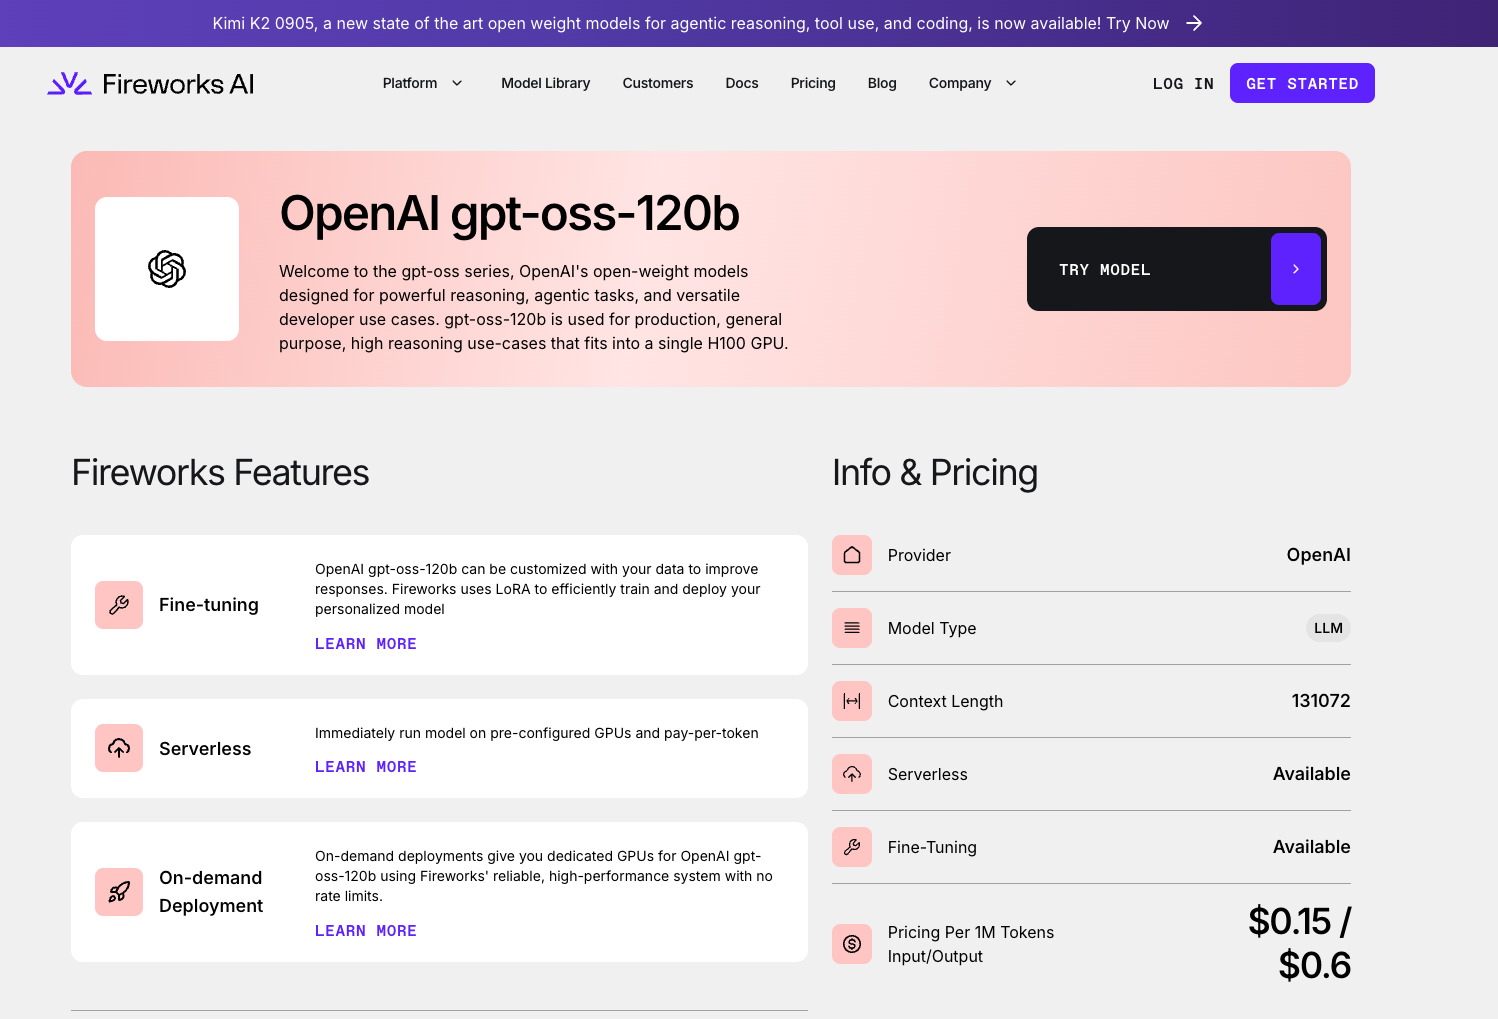

In [ ]:
# set api keys
import os
from dotenv import load_dotenv

os.environ['OPENAI_API_KEY'] =
os.environ["JUDGMENT_API_KEY"] =
os.environ["JUDGMENT_ORG_ID"] =
os.environ["FIREWORKS_API_KEY"] =


load_dotenv()

False

In [ ]:
from judgeval.data import Example
import requests
import openai
import os
import json
import random
from dotenv import load_dotenv
from judgeval.trainer import JudgmentTrainer, TrainerConfig
from judgeval.tracer import Tracer, wrap
from judgeval.scorers.example_scorer import ExampleScorer
from judgeval.trainer.trainable_model import TrainableModel


# Agent Environment Setup
Here, we use the wikipedia python library to access link choosing and following. The goal of this cell is to instantiate a few helper functions which the agent can call to access various links within Wikipedia. For more information about the documenation and functionality of this API, go to the [Wikipedia documentation page](https://wikipedia.readthedocs.io/en/latest/code.html#api).


There are many helper functions in the following cell, all existing to ease and clean the agentic code later in the notebook. If you wish to remove some of these functions or construct additional helper functions, feel free to do so.

In [ ]:
# wikipedia helper functions
def get_wikipedia_links(page_title: str) -> list:
    """Get all links from a Wikipedia page"""
    url = "https://en.wikipedia.org/w/api.php"

    headers = {
        'User-Agent': 'WikipediaRacingBot/1.0 (https://example.com/contact) requests/2.28.1'
    }

    params = {
        'action': 'query',
        'format': 'json',
        'titles': page_title,
        'prop': 'links',
        'pllimit': 'max'
    }

    try:
        response = requests.get(url, params=params, headers=headers)
        data = response.json()

        pages = data['query']['pages']
        page_id = list(pages.keys())[0]

        if page_id == '-1':
            return []

        links = pages[page_id].get('links', [])
        link_titles = [link['title'] for link in links]
        return link_titles

    except Exception as e:
        print(f"Error: {e}")
        return []

def filter_available_links(links, visited_pages, target_page=None):
    filtered = []

    for link in links:
        # Skip visited pages
        if link in visited_pages:
            continue

        # Skip meta/technical links
        skip_patterns = [
            'wikipedia:', 'category:', 'template:', 'file:', 'help:',
            '(disambiguation)', 'list of', 'timeline of', 'history of'
        ]
        if any(pattern in link.lower() for pattern in skip_patterns):
            continue

        # unlikely we want a specific event. It's easier to hardcode some of this out to keep the agent focused on broaded link clicks
        if any(year in link for year in ['1999', '2000', '2001', '2002', '2003', '2004', '2005']):
            continue

        if len(link.split()) > 4:
            continue

        filtered.append(link)

    if target_page:
        filtered = rank_links_by_relevance(filtered, target_page)
    else:
        # If no target, at least deprioritize numbered/address links
        filtered = deprioritize_bad_links(filtered)

    return filtered[:15]  # Return top 15

def rank_links_by_relevance(links, target_page):
    # rank by relevancy
    target_lower = target_page.lower()

    def relevance_score(link):
        link_lower = link.lower()
        score = 0

        # Exact match gets highest score
        if link_lower == target_lower:
            return 1000

        # Partial matches
        if target_lower in link_lower or link_lower in target_lower:
            score += 100

        # Geographic targets - prioritize location-related links
        if any(geo_term in target_lower for geo_term in ['california', 'mountain view', 'seattle', 'chicago']):
            if any(geo_word in link_lower for geo_word in ['city', 'county', 'state', 'california', 'united states', 'geography']):
                score += 50

        # Company targets - prioritize business-related links
        if any(biz_term in target_lower for biz_term in ['apple', 'google', 'microsoft', 'tesla']):
            if any(biz_word in link_lower for biz_word in ['company', 'corporation', 'inc.', 'technology', 'business']):
                score += 50

        # Heavily penalize numbered addresses and technical specs
        if link.split()[0].isdigit():
            score -= 200

        # Penalize very specific technical terms
        if any(tech in link_lower for tech in ['battery', 'protocol', 'specification']):
            score -= 100

        # Boost common conceptual links
        if any(concept in link_lower for concept in ['history', 'culture', 'economy', 'geography']):
            score += 20

        return score

    # Sort by relevance score (highest first)
    return sorted(links, key=relevance_score, reverse=True)

# bad links
def deprioritize_bad_links(links):
    good_links = []
    bad_links = []

    for link in links:
        # Check if it starts with numbers (addresses, technical specs)
        if link.split()[0].isdigit():
            bad_links.append(link)
        else:
            good_links.append(link)

    # Return good links first, then bad links
    return good_links + bad_links

# Dataset Creation
Now, in order to run an RFT job, we will need a training and test set. Since our domain is quite broad, we can use any examples as long as they're generally diverse and interesting. Here, we'll create a small sample dataset of 4 easy examples, 6 medium examples, and 6 harder examples. Feel free to change both the quantity and content of these examples to match your interests and use case! NOTE: 16 examples is probably too small for a training task of this difficulty, but this notebook is more of a demonstration of the process at large. If you want more definitive results, increase the size of this set.

In [ ]:
# create a sample dataset
def create_small_wikipedia_dataset():
    """Create small focused dataset like 2048 (16 examples)"""

    small_dataset = [
        # Easy (2-3 hops) - Same domain connections
        {"start_page": "MacBook", "target_page": "Apple Inc.", "max_clicks": 4, "difficulty": "easy"},
        {"start_page": "iPhone", "target_page": "California", "max_clicks": 4, "difficulty": "easy"},
        {"start_page": "Albert Einstein", "target_page": "Germany", "max_clicks": 4, "difficulty": "easy"},
        {"start_page": "Pizza", "target_page": "Italy", "max_clicks": 4, "difficulty": "easy"},

        # Medium (4-5 hops) - Cross category but logical
        {"start_page": "MacBook", "target_page": "California", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Google", "target_page": "Mountain View", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Tesla, Inc.", "target_page": "Elon Musk", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Microsoft", "target_page": "Seattle", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Albert Einstein", "target_page": "Physics", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Barack Obama", "target_page": "Chicago", "max_clicks": 6, "difficulty": "medium"},

        # Hard (6+ hops) - Very different domains
        {"start_page": "MacBook", "target_page": "Pizza", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Albert Einstein", "target_page": "Basketball", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Google", "target_page": "Coffee", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Python (programming language)", "target_page": "Taylor Swift", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Quantum computing", "target_page": "McDonald's", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Basketball", "target_page": "Philosophy", "max_clicks": 8, "difficulty": "hard"},
    ]

    return small_dataset

# Create the dataset
wikipedia_small_dataset = create_small_wikipedia_dataset()

# Convert to training prompts format
wikipedia_training_prompts = [
    {
        "start_page": ex["start_page"],
        "target_page": ex["target_page"],
        "max_clicks": ex["max_clicks"]
    }
    for ex in wikipedia_small_dataset
]

print(f"Created {len(wikipedia_training_prompts)} training examples")

Created 16 training examples


This creates a test dataset we can use for evaluation. It follows the same principles as the training set we created above.

In [ ]:
# Create a test dataset (separate from training)
def create_wikipedia_test_dataset():
    """Create test dataset with similar difficulty distribution but different page pairs"""

    test_dataset = [
        # Easy (2-3 hops) - Same domain connections
        {"start_page": "iPad", "target_page": "Apple Inc.", "max_clicks": 4, "difficulty": "easy"},
        {"start_page": "Samsung Galaxy", "target_page": "South Korea", "max_clicks": 4, "difficulty": "easy"},
        {"start_page": "Marie Curie", "target_page": "France", "max_clicks": 4, "difficulty": "easy"},
        {"start_page": "Sushi", "target_page": "Japan", "max_clicks": 4, "difficulty": "easy"},

        # Medium (4-5 hops) - Cross category but logical
        {"start_page": "iPhone", "target_page": "Silicon Valley", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Amazon (company)", "target_page": "Jeff Bezos", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "SpaceX", "target_page": "Mars", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Netflix", "target_page": "Los Gatos, California", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Isaac Newton", "target_page": "Mathematics", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Joe Biden", "target_page": "Delaware", "max_clicks": 6, "difficulty": "medium"},

        # Hard (6+ hops) - Very different domains
        {"start_page": "iPad", "target_page": "Pasta", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Marie Curie", "target_page": "Tennis", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Facebook", "target_page": "Tea", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "JavaScript", "target_page": "Beyoncé", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Artificial intelligence", "target_page": "Starbucks", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Soccer", "target_page": "Astronomy", "max_clicks": 8, "difficulty": "hard"},
    ]

    return test_dataset

# Create the test dataset
wikipedia_test_dataset = create_wikipedia_test_dataset()

# Convert to test prompts format
wikipedia_test_prompts = [
    {
        "start_page": ex["start_page"],
        "target_page": ex["target_page"],
        "max_clicks": ex["max_clicks"]
    }
    for ex in wikipedia_test_dataset
]

print(f"Created {len(wikipedia_test_prompts)} test examples")

Created 16 test examples


# Reward Models
With the eventual goal of using RFT on this agent, we need a reward model. In this case, we define the following scorer which gives the agent points based on if it wins, uses fewer clicks, doesn't repeat or go in circles, and persists towards the task. Feel free to change these rewards as you see fit!

# Scorer
Notice the class input of type ```ExampleScorer```. This class extends the ```BaseScorer``` class and requires the user to implement

```async def a_score_example(self, example: Example, *args, **kwargs) -> float:```

This method will asynchronously score each example, and the scorer should set three key fields:



*   ```self.name``` : scorer name shown in the Judgment Labs platform dashboard
*   ```self.score``` : numeric metric value (e.g., Pass@k in ```[0, 1]```)
*   ```self.reason``` : human-readable explanation or context behind the score







In [ ]:
class WikipediaRacingScorer(ExampleScorer):
    """
    Scorer for Wikipedia racing games that evaluates agent performance.

    Awards full points for winning the game, with bonuses for efficiency and path quality.
    Provides partial credit for failed attempts based on progress and strategy.
    """
    score_type: str = "WikipediaRacing"

    async def a_score_example(self, example: Example, *args, **kwargs) -> float:
        """
        Score a Wikipedia racing attempt based on success, efficiency, and path quality.

        Scoring breakdown:
        - Win: 1.0 base + up to 0.3 efficiency + up to 0.2 path quality (max 1.0 total)
        - Loss: up to 0.5 partial credit for progress and strategy

        Args:
            example (Example): Contains input data and agent output

        Returns:
            float: Score between 0.0 and 1.0
        """
        # Extract and validate agent output
        actual_output = getattr(example, 'actual_output', None)
        input_data = getattr(example, 'input', {})

        print(f"Input: {input_data}")
        print(f"Actual output type: {type(actual_output)}")
        print(f"Actual output: {actual_output}")

        # Parse agent results from output
        agent_results = self._parse_agent_results(actual_output)
        if agent_results is None:
            return 0.0

        # Extract game metrics
        game_won = agent_results.get("game_won", False)
        clicks_used = agent_results.get("clicks_used", 0)
        path_history = agent_results.get("path_history", [])
        max_clicks = agent_results.get("max_clicks", 8)

        print(f"Extracted: Won={game_won}, Clicks={clicks_used}, Path length={len(path_history)}")
        print(f"Path: {' → '.join(path_history) if path_history else 'No path'}")

        # Calculate score based on win/loss
        if game_won:
            # Base reward for winning
            success_reward = 1.0

            # Efficiency bonus: fewer clicks is better
            efficiency_reward = max(0.1, 1.0 - (clicks_used - 1) / (max_clicks - 1) * 0.8)

            # Path quality bonus: unique pages vs total clicks
            path_quality = len(set(path_history)) / len(path_history) if path_history else 0

            # Combine rewards (max 2.0) and normalize to [0, 1]
            total_reward = success_reward + (efficiency_reward * 0.3) + (path_quality * 0.2)
            final_score = min(total_reward, 2.0) / 2.0

            print(f"Full reward: {final_score}")
            return final_score

        # Calculate partial credit for failed attempts
        partial_score = 0.0

        # No progress made - return early
        if clicks_used == 0:
            print("Final partial reward: 0.0")
            return 0.0

        # Reward for making any moves
        partial_score += 0.15
        print("+0.15 for making moves")

        # Reward for avoiding circular navigation
        if path_history:
            unique_ratio = len(set(path_history)) / len(path_history)
            circle_bonus = unique_ratio * 0.2
            partial_score += circle_bonus
            print(f"+{circle_bonus:.3f} for avoiding circles ({unique_ratio:.2f} unique ratio)")

        # Reward for multiple attempts
        if clicks_used >= 2:
            partial_score += 0.1
            print("+0.1 for multiple moves")

        # Reward for using most available clicks (persistence)
        if clicks_used >= max_clicks - 1:
            partial_score += 0.05
            print("+0.05 for persistence")

        # Cap partial credit at 0.5 and return
        final_partial = min(partial_score, 0.5)
        print(f"Final partial reward: {final_partial}")
        return final_partial

    def _parse_agent_results(self, actual_output) -> dict | None:
        """Parse agent output into a dictionary of results."""
        # Handle dict output
        if isinstance(actual_output, dict):
            print("Found agent results in actual_output (dict)")
            return actual_output

        # Handle JSON string output
        if isinstance(actual_output, str):
            try:
                import json
                agent_results = json.loads(actual_output)
                print("Found agent results in actual_output (parsed JSON)")
                return agent_results
            except:
                print("actual_output is string but not valid JSON")
                return None

        # Invalid output type
        print("actual_output is not dict or string")
        return None

# Setting Up Our Agent

Now that we have finished constructing the agent environment and reward function, we must construct the agent itself. The agent code will use a
`TrainableModel` from Fireworks, so let's get our model deployed first. See screenshot below for Fireworks Deployed Models UI. The `model_id` can be whatever name you specifcy, `user_id` will be your username upon signing up for an account, and deployment_id is shown above. In this case it is: `lyha980l-v8-v1jsqktg`

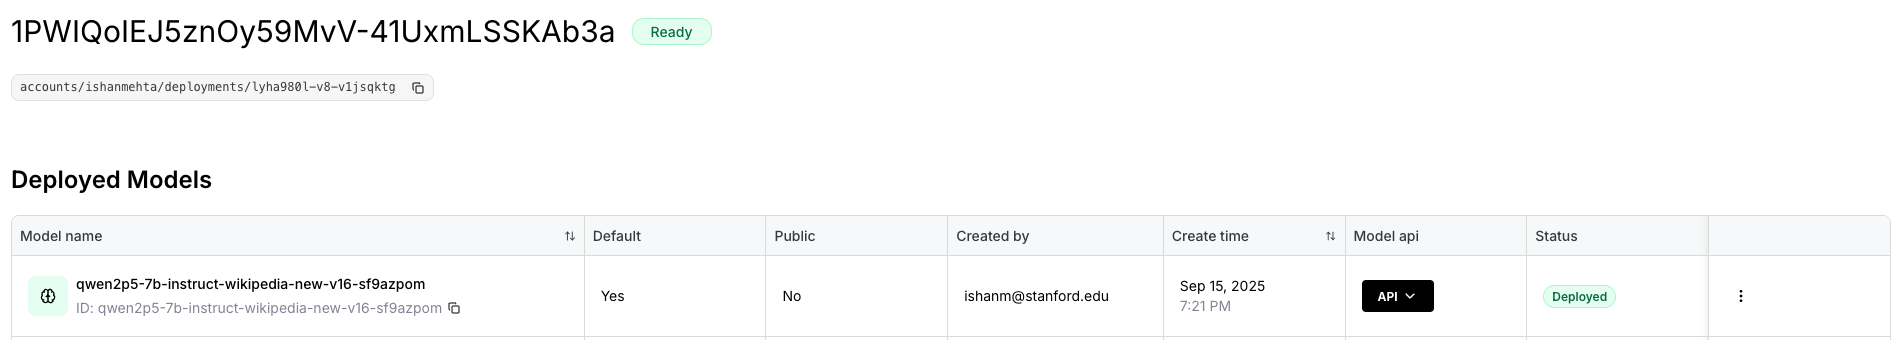

As we write the agent, we will integrate it's model calls and tool calls to set up for our reinforcement learning module.

For more information about Judgment `Tracer`, `wrap()`, and `ExampleScorer`, check out these documents:

https://docs.judgmentlabs.ai/documentation/tracing/introduction#tracing
https://docs.judgmentlabs.ai/documentation/evaluation/scorers/introduction

In order to integrate with our base agent code, we will use the `Tracer` to instrument all function calls with the `@judgment.observe` decorator to collect function metadata, as well as the `wrap()` method that allows us to capture metadata about the LLM (hosted on Fireworks) instrumented with `TrainableModel` and `TrainerConfig`.

To make the instrumentation clearer, any judgeval code will be highlighted in comment blocks outside of the `@judgment.observe` decorators.

In [ ]:
from judgeval.trainer import JudgmentTrainer, TrainerConfig
from judgeval.tracer import Tracer, wrap
import os
from dotenv import load_dotenv
from judgeval.scorers.example_scorer import ExampleScorer
from judgeval.data import Example
from judgeval.trainer.trainable_model import TrainableModel
from judgeval.trainer.config import TrainerConfig
import re
import random

load_dotenv()

False

The `wrap()` function is a key judgeval feature that adds tracing capabilities
to your model. This allows judgeval to automatically track:
- All model calls
- Input prompts and responses
- Latency and token usage
- Error states

Here we're using a Qwen model, but you can wrap any model that follows
the OpenAI chat completions interface.

In [ ]:
# JUDGEVAL INTEGRATION
model = wrap(TrainableModel(
    TrainerConfig(
        base_model_name="qwen2p5-7b-instruct",
        model_id="qwen2p5-7b-instruct-wikipedia-new-updated",
        user_id="ishanmehta",  # Replace with your user_id
        deployment_id="lyha980l-v8-v1jsqktg"  # Replace with your deployment_id
    )
))

🔵 [Model] Creating and deploying base model...
  └─ Creating base model instance...
  └─ Applying deployment configuration...
🔵 [Model] Base model deployment ready


# Tracer
The `Tracer` creates a project in judgeval where all traces will be logged.
Every function decorated with `@judgment.observe()` will appear in this project,
allowing you to see the full execution tree of your agent.

**Arguments:**
- `project_name`: Name of your judgeval project
- `api_key`: Your judgeval API key (get this from the dashboard)

In [ ]:
judgment = Tracer(
    project_name="wikipedia-racing-small",  # Name your project
    api_key=os.getenv("JUDGMENT_API_KEY")  # Get this from judgeval dashboard. Also instantiated above.
)


# Decorator
The `@judgment.observe()` decorator tells judgeval to create a span for this function.
A span captures:
- Function inputs and outputs
- Execution time
- Any nested function calls

**Parameters:**
- `span_type`: The type of operation ("function", "llm", "tool", etc.)

This function gets a response from our wrapped model given the conversation history.

In [ ]:
@judgment.observe(span_type="function")
async def get_model_response(messages: list) -> str:
    """Get a response from the model for the current conversation state."""
    response = await model.chat.completions.acreate(
        messages=messages,
        max_tokens=100,
        temperature=0.7,
        n=1,
    )
    return response.choices[0].message.content.strip()


This function handles one decision in the Wikipedia race:
1. Formats the current state (page, target, available links) into a prompt
2. Gets the model's decision
3. Updates the conversation history

By wrapping this with `@judgment.observe()`, you can see in judgeval:
- What links were available at each step
- What the model chose
- How long the decision took

In [ ]:
@judgment.observe(span_type="function")
async def process_navigation_turn(messages: list, current_page: str, target_page: str,
                                available_links: list, click_count: int, max_clicks: int) -> tuple:
    """Process a single navigation turn."""

    # Create user prompt for this turn
    links_text = "\n".join([f"- {link}" for link in available_links[:15]])

    user_prompt = f"""Wikipedia Racing Navigation:

Current page: {current_page}
Target page: {target_page}
Clicks used: {click_count}/{max_clicks}

Available links from this page:
{links_text}

Choose ONE link that gets you closer to "{target_page}".
Respond with ONLY the exact link name from the list above."""

    # Add user message
    messages.append({"role": "user", "content": user_prompt})

    # Get model response
    assistant_response = await get_model_response(messages)

    # Add assistant response
    messages.append({"role": "assistant", "content": assistant_response})

    return messages, assistant_response

# Agentic Loop
This is the core agent that orchestrates the entire race.

**Why trace the entire agent?**
- Creates a top-level span in judgeval containing all sub-operations
- Lets you see the complete execution tree for one race
- Makes it easy to compare different runs side-by-side

**The agent loop:**
1. Check if target reached (win condition)
2. Get available links from current page
3. Ask model to choose the best link
4. Validate and execute the choice
5. Repeat until target reached or max clicks exceeded

In [ ]:
@judgment.observe(span_type="function")
async def wikipedia_racing_agent(start_page, target_page, max_clicks, **kwargs):
    """
    Wikipedia racing agent that navigates from start to target page. It returns a
    dict with game results and conversation history
    """

    # Initialize game state
    current_page = start_page
    path_history = [start_page]
    click_count = 0

    # Initialize conversation
    messages = [
        {
            "role": "system",
            "content": f"You are an expert Wikipedia navigator. Your goal is to get from '{start_page}' to '{target_page}' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."
        }
    ]
    responses = []

    # Game loop
    while click_count < max_clicks:
        # Check win condition
        if _normalize_title(current_page) == _normalize_title(target_page):
            break

        # Get available links with relevance ranking
        raw_links = get_wikipedia_links(current_page)
        available_links = filter_available_links(raw_links, path_history, target_page)

        if not available_links:
            break

        # Get model's choice
        messages, assistant_response = await process_navigation_turn(
            messages, current_page, target_page, available_links,
            click_count, max_clicks
        )
        responses.append(assistant_response)

        # Parse and validate choice
        chosen_link = assistant_response.replace("<|im_start|>", "").replace("<|im_end|>", "").strip()

        # Find best match from available links
        valid_choice = None
        for link in available_links:
            if chosen_link.lower() == link.lower() or chosen_link in link:
                valid_choice = link
                break

        if not valid_choice:
            # Fallback to first available link
            valid_choice = available_links[0]

        # Make move
        current_page = valid_choice
        path_history.append(valid_choice)
        click_count += 1

    # Determine success
    game_won = _normalize_title(current_page) == _normalize_title(target_page)

    # Debug logging
    print(f"Agent returning: Won={game_won}, Clicks={click_count}, Path={len(path_history)}")
    print(f"Path: {' → '.join(path_history)}")

    # return in this format so agent/scorers are aligned
    return {
        "messages": messages,
        "responses": responses,
        "start_page": start_page,
        "target_page": target_page,
        "max_clicks": max_clicks,
        "game_won": game_won,
        "clicks_used": click_count,
        "path_history": path_history
    }

Helper function to normalize Wikipedia page titles for consistent comparison.

In [ ]:
def _normalize_title(title):
    return title.lower().strip().replace("_", " ").replace("-", " ")

# Baseline
First, let's run a quick baseline so we have a starting point. Whenever you are running some sort of enhancement on a model (SFT, RFT, etc...), make sure you baseline your progress before the enhancement. This is important since it demonstrates exactly how much your methodology improved upon existing capabilities. We can see the output of the cell below has us at a success rate of about 56.2%

In [ ]:
# Cell: Baseline Evaluation on Training Set (Before Training)
"""
## Baseline Performance on Training Set

Before training, let's evaluate the base model's performance on the training set.
This gives us a baseline to compare against after training.
"""

print(f"{'='*50}")
print(f"Running BASELINE evaluation on {len(wikipedia_training_prompts)} training examples...")
print(f"{'='*50}\n")

# Run baseline evaluation on training set
baseline_results = []
baseline_total_score = 0.0

for i, prompt in enumerate(wikipedia_training_prompts, 1):
    print(f"[Baseline {i}/{len(wikipedia_training_prompts)}] Evaluating: {prompt['start_page']} → {prompt['target_page']}")

    # Run the agent with the base model (before training)
    result = await wikipedia_racing_agent(**prompt)

    # Score the result
    scorer = WikipediaRacingScorer()
    score = await scorer.a_score_example(Example(input=prompt, actual_output=result))

    baseline_total_score += score

    baseline_results.append({
        "prompt": prompt,
        "result": result,
        "score": score,
        "game_won": result.get("game_won", False),
        "clicks_used": result.get("clicks_used", 0)
    })

    print(f"  Score: {score:.3f} | Won: {result.get('game_won')} | Clicks: {result.get('clicks_used')}\n")

# Calculate baseline aggregate metrics
baseline_avg_score = baseline_total_score / len(baseline_results)
baseline_success_rate = sum(r['game_won'] for r in baseline_results) / len(baseline_results)
baseline_avg_clicks = sum(r['clicks_used'] for r in baseline_results) / len(baseline_results)
baseline_avg_clicks_won = sum(r['clicks_used'] for r in baseline_results if r['game_won']) / max(sum(r['game_won'] for r in baseline_results), 1)

print(f"\n{'='*50}")
print(f"📊 BASELINE Training Set Performance")
print(f"{'='*50}")
print(f"Average Reward:       {baseline_avg_score:.3f}")
print(f"Success Rate:         {baseline_success_rate:.1%} ({sum(r['game_won'] for r in baseline_results)}/{len(baseline_results)} won)")
print(f"Avg Clicks (all):     {baseline_avg_clicks:.2f}")
print(f"Avg Clicks (won):     {baseline_avg_clicks_won:.2f}")
print(f"{'='*50}\n")

# Store baseline metrics for later comparison
baseline_metrics = {
    "avg_score": baseline_avg_score,
    "success_rate": baseline_success_rate,
    "avg_clicks": baseline_avg_clicks,
    "avg_clicks_won": baseline_avg_clicks_won,
    "results": baseline_results
}

print("✅ Baseline metrics saved in 'baseline_metrics' variable")

Running BASELINE evaluation on 16 training examples...

[Baseline 1/16] Evaluating: MacBook → Apple Inc.
Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.
Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman

# Trainer
Now the magic happens! We simply use the ``` JudgmentTrainer() ```
function with our tracer, model, configuration, agent, prompts, scorer, and the Fireworks provider and we have a trained agent!

To read and understand more about the ``` JudgmentTrainer() ``` function, you can browse the [judgeval](https://github.com/JudgmentLabs/judgeval/tree/main/src/judgeval/trainer) repository.

Under the hood, each prompt from the `prompts` will be passed to our agent function which produces a rollout. Each rollout will be scored with the `WikipediaRacingScorer` and the rewards will be used to update the model weights according to Fireworks' implementation of GRPO.

In [ ]:
trainer = JudgmentTrainer(
    tracer=judgment,
    project_name="wikipedia-racing-small",
    trainable_model=model,
    config=TrainerConfig(
        base_model_name="qwen2p5-7b-instruct",
        model_id="qwen2p5-7b-instruct-wikipedia-new-updated",
        user_id="ishanmehta",
        deployment_id="lyha980l-v8-v1jsqktg",
        num_steps=16,
        num_prompts_per_step=8,
        num_generations_per_prompt=4
    )
)
await trainer.train(
    agent_function=wikipedia_racing_agent,
    scorers=[WikipediaRacingScorer()],
    prompts=wikipedia_training_prompts,
    rft_provider="fireworks"
)

✅ [Training] Starting reinforcement learning training
✅ [Step 3/16] Starting training step 3
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v2
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1443.33Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=617329;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/9162b089-6caa-468c-b474-20d1f3c9281c\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 720.18Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=502990;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/558f50fa-8524-4ee3-a235-1eeee71d1c50\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1600.88Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=737183;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/0a1f1a2a-83cd-4c2d-a777-ec57808f7819\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1333.64Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=396863;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6fbbb67c-2be9-4b13-addd-efd4d8f2c331\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 986.43Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=380190;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/51b50bcd-c63f-40c3-8d48-061154136ebe\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1696.04Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=901518;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/af51bc06-fc7b-4020-ba82-86efdfbca487\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1496.36Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=727367;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/0041a2dd-59a0-4e09-88b6-396d72f237ea\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1444.82Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=17144;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6e516e75-d649-4937-a883-fb7d0cac5d95\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1599.66Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=159399;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/7ab98ac3-9f7e-419f-80d3-ac38ee07d870\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1538.07Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=254501;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ab69cc03-fd3c-4ec3-9eab-a9d144863ae2\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1432.48Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=38901;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/7561bb2b-e764-4a1a-b9c1-2c32e8ce3610\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1718.98Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=374198;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d1a8c3f0-ea2d-4cfd-8762-5d79ad24f4c0\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 756.28Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=869628;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/dc525044-b681-48bb-857a-84b84c9b5992\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1812.58Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=453575;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/59f564dc-db17-476e-8541-5205e17fe3cc\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1770.50Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=727578;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/58028740-71be-4852-9658-e6d805d03715\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1231.45Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=523493;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b28f1c2d-980f-4fa4-88e4-da5c44447aed\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1292.94Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=654057;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/2fe642b3-3560-4c21-8350-e7c6c4ac3d4e\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1780.26Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=40109;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/295ed1b3-bb2d-4277-b9ed-99b6f5e1b895\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1630.12Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=587780;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/04ebe6cc-4e2c-476e-b12b-73c41c99b27f\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1527.42Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=226842;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/17758566-ec6c-410a-a9a8-85252b35bc81\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1221.40Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=638748;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d5722090-ae95-4e81-a6c8-dc7006c7532f\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1277.97Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=521622;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/69152097-b99c-4b46-accd-388e8bf2f592\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1359.58Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=683293;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/1171522b-90f8-4296-840a-7b24781f31f0\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1421.32Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=440420;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3e87749b-977d-424e-b897-3b1891c66791\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1373.83Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=647054;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e55df54a-9509-405f-8b95-223ffe60a0a7\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1275.64Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=340090;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/99821902-1894-4845-8483-b0b0210f7f79\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1128.71Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=649301;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/83b58876-5bda-4739-8d3e-5319ebae6bf7\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:S → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1184.83Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=143651;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/4bb7a7ec-7946-422e-9728-d717d4753c79\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → AppleCD → Apple II → AirPods → AirPods Max → AirPods Pro


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1291.75Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=295165;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e58b35e5-afcf-4a8e-b6fd-4888fd6b0e57\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 969.11Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=809807;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/91de0316-1730-41ed-92c1-b1008ad29502\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → AppleCD → Apple II → Advertising → Market economy → Culture of capitalism


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1429.06Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=351390;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c47ce879-d30d-402f-a210-f3f4bd828860\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 1080i → 480i → 480p → 14:9 aspect ratio → 4:3


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 958.26Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=714445;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a0442197-73fe-4df5-995e-5773e6af520b\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 3/16] Preparing training dataset
✅ [Step 3/16] Preparing training dataset - Complete
✅ [Step 3/16] Starting reinforcement training
🔄 [Step 3/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 3/16] Training job in progress - Complete
✅ [Step 3/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v3
✅ [Step 4/16] Starting training step 4
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v3
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1265.63Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=551224;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/96e74b75-bbdb-491e-9ca6-650d38370ffd\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1242.39Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=307001;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/35926e3b-fd60-424d-b9f9-1ecfd17a28d5\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1411.75Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=48745;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/5fd52a03-329e-42d2-9a8d-7fbda41fccd0\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1629.49Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=661154;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c4e823e6-d78e-46cf-b3f6-287fcc309f14\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1338.32Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=650335;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/2060de54-738a-4f0a-abb8-b65caecdcfda\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1720.39Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=798449;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a1a06e3d-a817-44fd-bb7b-bf048104e5dd\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1857.53Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=240204;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/091039fb-ab87-4ec9-822d-0c44d61f16e7\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 862.67Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=496694;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/0524bb60-3f95-4623-b8c4-efc2f446f93b\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1681.08Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=924289;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/031840c8-8653-43c5-84ab-f3a1f69ffbbb\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1691.25Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=386342;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ac2b08da-a6ac-455c-a159-22c0c5db9b28\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1565.04Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=615936;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/2bdc77e7-6e0a-4abd-900c-3024a3a8c650\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1526.87Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=990467;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3787b400-75b2-448a-a207-22bec8c7dd4a\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1759.36Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=595551;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/64ec07de-f2d1-4c51-85f5-b5cf8d7d2f11\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1532.45Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=481803;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f031d424-fe16-4bb1-91ce-7b41127e4e2e\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1605.17Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=777404;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/7e289a9f-bc82-4e84-9e55-ff727dd79362\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1757.88Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=431673;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/5d0b32f3-6325-435b-9233-848a375bd90b\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1565.04Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=870780;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/26a28459-aa2a-4f8d-8f96-5b42b44a968f\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1459.90Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=91801;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6063cf63-d5fa-4524-b61d-9f098fb6fe37\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 880.42Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=192030;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/1a60877f-abf8-48db-bf42-2646dc101ab8\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1007.52Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=842700;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/36fc105b-fc29-4aab-b850-559570bae562\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1447.81Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=838991;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/16b7d0d1-595d-4ada-814c-77133066b60a\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1504.95Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=16715;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/835eaafc-8862-4bd7-9c15-6146a3c28335\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1544.29Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=665075;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b1258162-fbc9-4fd4-9d73-781875c86168\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1413.18Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=157037;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/bd86d369-b4e2-4b47-bf01-60de80624be9\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1076.57Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=196996;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f4315f83-d28b-410d-a737-629982520524\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1289.36Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=637914;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/dc445ad0-6f55-4114-88f9-eaecefb5eb33\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:L → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1285.02Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=171521;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/fda17af2-f246-44dc-8132-606dd09dbdf1\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → AppleCD → Apple II → Advertising → 2D barcode → Barcode


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 456.25Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=892265;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/82c14f1b-37a2-4575-969e-ef074dbe224e\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1299.75Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=688842;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8bf246d4-a47a-40e0-b425-4f2a96dca571\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1421.32Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=544177;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8855aba1-88fc-4681-8976-e2b55d73a58d\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 795.13Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=76211;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/53fc75e6-d2d2-4481-a655-c518f99bf755\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → 4K resolution → 16:9 aspect ratio → Aspect ratio (image) → 21:9 aspect ratio


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1054.91Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=253479;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f3e9de85-259b-4c3a-bd4b-9e59fee6613a\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 4/16] Preparing training dataset
✅ [Step 4/16] Preparing training dataset - Complete
✅ [Step 4/16] Starting reinforcement training
🔄 [Step 4/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 4/16] Training job in progress - Complete
✅ [Step 4/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v4
✅ [Step 5/16] Starting training step 5
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v4
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1490.51Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=362874;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e6bf2e88-dd9a-4e75-9c44-23ccce905f17\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1731.75Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=66842;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/dc5373b7-d0e2-47a8-8075-d53045cc5c37\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1745.44Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=622947;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/0e154596-251a-41dc-a427-05795b85cc11\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1520.78Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=51928;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/5f1f9471-aa7c-4ac4-a7e5-0e36c1de377f\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1787.09Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=502867;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ecd42196-40ff-41e7-81da-7b59b155a319\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1558.64Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=768554;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/145c8aba-2c4f-4dee-89d2-7386a50e5540\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1390.68Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=827224;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e1f85c9c-cb4f-4889-acce-7e8737d382f4\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1655.86Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=997802;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/02e3665c-1405-43fb-81e1-8eac8f18bd64\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1426.63Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=703199;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/289c2db3-0efd-4b01-93ea-5dc3b085339b\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 735.46Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=936241;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/12dd3496-6f4e-4b0f-b82d-8f2402f00092\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 645.28Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=38539;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/361b8f75-c7cf-46e4-a14d-1c4456a8535a\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1667.72Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=7360;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/349150c1-9e28-4ae8-a52b-3929362566c7\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1249.42Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=779466;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e867f16f-8b14-488f-a156-2769307206de\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1626.96Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=841810;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/eb7b6ae3-8504-4940-9a28-66f5d65b7bcc\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1813.36Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=31453;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6910b8a3-164f-4335-b046-6c9ce6a60256\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 588.34Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=213718;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/beae2bf1-9124-4e1a-8e00-9c718f92b31c\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 841.38Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=948428;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/848fad5d-0ded-4aac-9016-a1972e638091\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1290.95Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=918222;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b3ee2df5-bd7b-4657-a1a9-be502d8350ba\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1668.38Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=459144;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/daeb8ba2-c524-4af1-b700-a01bbeac59c3\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1593.58Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=288144;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/4ae8b5cd-c214-4ac3-8718-d7f89efe8dba\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1072.71Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=767923;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ed0e9d5d-119f-45ed-a057-91f398a6b76e\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 614.37Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=931175;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/2d06c890-a95d-43f9-a78a-036de261329c\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1368.90Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=563227;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/41c7991f-4c97-46d4-b921-c51a870bfcef\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1447.31Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=70264;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f9313758-2e4d-4e2d-9cb7-fec286798a25\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1125.99Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=463813;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ed56eb9a-706d-4879-b46a-f5cd8d0309ed\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 823.54Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=578335;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6c4a6965-777a-42dc-9942-e69416f03dc0\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1534.69Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=903588;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/73405d51-c844-4b11-9a3e-ec73bf87e817\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1512.01Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=839802;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/cbb045db-4a22-475f-ad89-84b432b42324\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1286.99Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=927532;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/1ee23b01-7e29-4344-876e-34e774701fdf\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:S → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 687.14Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=122540;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d25228d4-0a74-44a2-afbe-51b54c37b618\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 669.27Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=695477;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/75b45214-d4d4-45b7-938f-959dd6c56997\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1640.96Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=914336;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c108afb4-4124-4822-b464-b5cc7ca74ca1\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 5/16] Preparing training dataset
✅ [Step 5/16] Preparing training dataset - Complete
✅ [Step 5/16] Starting reinforcement training
🔄 [Step 5/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 5/16] Training job in progress - Complete
✅ [Step 5/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v5
✅ [Step 6/16] Starting training step 6
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v5
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1448.31Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=556188;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/83263f9a-9c13-46cf-a9b6-6d313123b6c0\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1766.02Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=502996;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/0d4e9419-7937-4b6a-ab54-01ca12044ad1\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1878.33Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=593637;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/af798a04-70ef-48a4-94d4-6e4a91502652\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1392.99Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=543575;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/5f47f7b5-9e9f-45a1-a595-4296fd123f03\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1470.65Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=492027;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/19cf347c-fb05-4bf4-b63f-7da533e71f75\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1949.93Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=695775;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e6236fbc-969a-401b-a3bd-e4a95f9ad1e1\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1684.46Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=4610;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6348e1fc-cc43-42c6-b240-6caa46892b2d\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 760.80Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=26869;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ae668c9d-74c3-4a8d-8770-6ea4addc080f\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1615.06Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=851741;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3796a481-e942-4d3c-8961-aa50eaf17ba1\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1306.23Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=58888;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c8d07878-6ec5-4e4d-9fa0-a69b4a5d08e0\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1445.81Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=6498;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f452c68e-270d-4dff-9ce6-bcbcbe9fdf8f\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1818.08Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=492842;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/42e4dea8-b029-4f28-9138-f05cea46441c\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 784.28Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=863593;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b6e25b4d-97af-4810-88bd-3e2d36966dd4\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1451.82Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=185395;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/cb4ca667-f868-4079-af9a-a0b54931418c\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1387.46Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=51482;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/17dcb77c-b57b-4cd6-bbdb-dd1e648fd446\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1683.78Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=855257;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a56fb734-14aa-4a54-bb1e-1d1da76b773e\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1648.70Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=451107;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d40c7847-dff3-49ee-a75f-312384e21731\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1529.65Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=59547;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/80b0af42-edbb-47d6-a412-9017f09318d8\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1193.94Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=641223;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/cc581bdd-1137-400d-945c-6bb18e8e1809\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1486.29Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=849322;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/9bf75793-7c4c-4b21-a4ea-b7355c313281\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1658.48Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=838100;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/0fcdc565-0790-4ead-b8e8-7d9e57cc9efe\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1867.46Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=44053;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/194b4ccd-bdd8-49b6-9134-953995f4c4ef\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 932.27Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=435948;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/46748c8d-324e-46f0-9b01-74f72347e639\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 590.00Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=131056;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/43208de9-af4b-4b83-92a2-4a6b5b38f110\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1392.53Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=557209;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f94b263c-8275-472e-b8f0-c8c0d9e521e1\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:L → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 712.35Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=445449;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/bae2bfb7-ead7-414a-a092-fa3bf4045389\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1621.30Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=496044;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e6d0c9c7-fca1-44bf-bd27-bddce8013c52\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1633.93Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=770002;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/be4e2044-2305-4faa-9c93-be127f9d0f78\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1074.36Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=239489;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/aaeb04e4-a5d0-4868-8dcc-adb37ffb38aa\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1441.84Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=313747;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a3aa2efa-8311-4df5-8ea7-82f7c2a55193\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 787.22Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=94121;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/5a1bada8-04cf-4dcb-9a40-b0302241d1e2\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:L → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 824.19Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=520725;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/86ccc095-3f9a-4466-b828-132e70be7770\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 6/16] Preparing training dataset
✅ [Step 6/16] Preparing training dataset - Complete
✅ [Step 6/16] Starting reinforcement training
🔄 [Step 6/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 6/16] Training job in progress - Complete
✅ [Step 6/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v6
✅ [Step 7/16] Starting training step 7
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v6
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1835.58Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=97002;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ae7f6217-f91f-4239-9eeb-2b49056f7266\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1818.87Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=290504;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/bf3681bf-7d9a-47dc-9ba0-33f176575ef0\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1469.62Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=475328;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/fdfb1857-6bb2-4437-8902-1fe369850d60\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 446.35Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=259814;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c571b3e9-680b-4c60-8d83-d222114effe7\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1263.34Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=240917;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a09a32bc-0e28-4984-a67b-30ce59d3c2f7\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1039.74Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=928399;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b3984cbb-8e8d-455e-933a-f18cab4771cf\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 2128.01Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=996847;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a3aea789-7456-499a-886f-0730cbc7beb4\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1763.05Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=666306;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/06d8ce8f-c67b-4db8-9ec9-237ec347235e\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1607.01Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=462517;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/012fddb4-c614-4e4e-8a47-9ac99f8b92d5\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1284.23Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=563847;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/415733ce-38dd-4c13-9d45-ee90d6ad1499\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1697.41Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=234951;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/7acb657f-b859-4dd7-ad97-f0af4d218c54\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1855.89Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=877432;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/580768ae-6482-490b-bfe6-b97e776ccb5f\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1639.04Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=502914;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/15582c88-e725-4296-a70d-8b73b1190a16\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1525.20Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=208044;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a1944518-7c79-40a6-a9e3-7599f0f90194\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1587.55Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=55922;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/10182b07-50e8-4233-8590-4ab36cee19c5\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1551.72Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=699630;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/98a0ca4c-bd83-4be0-8262-edbaf65e93dd\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1366.67Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=834951;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/42397875-4935-4068-b9a3-4761bfea9a01\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 876.74Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=70774;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/fbcb233e-96c1-43f3-9e91-c312ae9f8c93\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1636.48Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=512911;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/de01c47b-c1e6-4e6e-9c38-3c51a90ac1ae\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1725.34Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=788677;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ded53d25-b40b-422f-8d0f-1939867ca5c2\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1653.25Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=124832;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8fa8c714-2a23-43d7-b8b7-91689460580b\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1623.81Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=241332;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8ca4a9e6-76af-4e59-a97f-b67be1a60a15\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1315.65Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=949935;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e7352b52-7d73-4512-b5db-ee3367c226e1\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1289.76Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=654968;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/fd05772e-9ff4-490a-9639-e9492bd7a777\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1377.44Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=921006;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d672d314-4e83-4560-afde-4bad80df2ddb\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → AppleCD → Apple II → AirPods → AirPods Max → AirPods Pro


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1564.46Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=932378;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a3d300c6-09fb-49d9-b99f-474ab1c9641a\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1423.25Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=83061;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/380403e2-4a8d-4497-b963-f7347d3fea19\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1355.63Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=685110;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/31c70b8c-3d90-40bf-9b8f-e786e6105924\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 683.00Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=693515;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/24dea8da-31d7-45e4-8cf9-61a1155d926a\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1222.83Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=322719;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/60f008cd-14ab-432a-bffb-1208240fdbcd\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:L → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1333.22Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=654408;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/74f9fb83-6008-404f-968c-12397b23bc27\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:S → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 485.79Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=514006;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f7abc33a-367d-4ba2-887d-84596738721c\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 7/16] Preparing training dataset
✅ [Step 7/16] Preparing training dataset - Complete
✅ [Step 7/16] Starting reinforcement training
🔄 [Step 7/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 7/16] Training job in progress - Complete
✅ [Step 7/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v7
✅ [Step 8/16] Starting training step 8
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v7
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...


/usr/local/lib/python3.12/dist-packages/fireworks/_logger.py:38: RuntimeWarning: coroutine 'ChatCompletion.acreate' was never awaited
  result = func(*args, **kwargs)


🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1647.41Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=124848;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/544e72ca-05b2-4d33-94d5-72d518501f8a\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1642.25Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=876102;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f91830ed-c664-4c16-88ef-0adf6cde8d3e\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 313.15Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=382023;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/bff1352b-89a7-46ca-8343-95081f501a6f\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 948.29Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=501185;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/85079135-d982-4597-be4d-3c5b12d8f491\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1737.49Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=682914;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a95f80ff-019a-4bab-9fa7-621ba0ee12ac\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1696.04Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=822315;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/870e3b6c-8d05-4318-a4bf-6918bcc90497\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1394.85Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=133611;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a56f2849-e927-46aa-92b6-017856ef191d\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1667.72Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=842658;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/050c7b30-9288-4483-8764-1ac1fe00da30\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1684.46Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=931891;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f73f2a19-9fea-49c3-9850-54e8d3e691f2\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 882.27Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=107542;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/0d52ec04-fe55-4ddc-9f60-a5da1b93ecf2\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1832.37Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=518168;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c38c4cbe-7830-44ac-b45a-ebb61f7f89cb\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1858.35Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=738544;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6d94174f-e33b-44dc-957a-d763f5890545\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1088.86Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=872729;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/09ee75fc-e07c-4199-a1a9-e2a887fd7c1e\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1494.76Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=430055;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a96ee33d-6586-4149-a473-0719603938eb\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1809.45Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=760373;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c7ddc1f9-1d5c-48d1-9393-875388af3ddc\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 954.34Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=136886;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3c94f557-499d-44aa-ae25-83adc13a241e\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1162.50Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=19019;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/33a6b451-94b2-490d-b477-8e126f130bf9\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1371.58Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=467911;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8fe8c206-cb41-45cc-8a51-d09e42a0afb3\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 757.50Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=307352;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/40080bfe-9970-4a62-93a0-a651fdd45670\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1582.76Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=627898;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f0fd4109-258b-4277-a156-794b74439df1\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 419.56Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=451889;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e5031220-77b8-4deb-94dc-aefa6db42545\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1673.04Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=398432;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f4f438a6-a912-4411-bfc6-87305f53b7d3\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1698.79Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=573390;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c566a8a5-98f2-43a9-977d-209445bd7d08\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 794.98Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=818244;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/665724fb-3993-4697-b3b2-51716f9c6a7d\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1212.93Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=101650;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8fa3ebb2-c713-45f1-a08e-54f24d02b4ab\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:S → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 707.06Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=578687;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f2bccac9-8191-435a-9d21-80975515481d\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1212.23Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=929505;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/43ca79b3-0264-4bfc-922e-7c9999c2ed40\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1353.00Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=261371;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6e905154-c704-4571-8aa1-806559ada823\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 467.07Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=454004;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b1e45629-c091-45f7-b45a-0e2cf70145e5\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1326.05Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=52071;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/25e6e535-cdf6-4b0a-9c51-cdc5a6f76d98\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1434.93Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=315907;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/bb394c70-b4cd-4400-9824-e18490ab51bf\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1513.10Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=12500;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/35231590-e678-4256-8070-6ecdd05094b1\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 8/16] Preparing training dataset
✅ [Step 8/16] Preparing training dataset - Complete
✅ [Step 8/16] Starting reinforcement training
🔄 [Step 8/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 8/16] Training job in progress - Complete
✅ [Step 8/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v8
✅ [Step 9/16] Starting training step 9
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v8
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1874.97Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=746206;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ba9fb9c2-ef19-4e71-8e67-1f8b64aaf856\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1891.03Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=461977;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d1c5c8b3-9d01-44a0-a865-2afb3a669c48\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 2024.28Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=552181;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/26ccae77-a5f3-4e48-94e2-47f5933ff63a\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1954.48Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=352848;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3424f8db-db3f-4faa-85cf-42383be319ba\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1712.66Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=225360;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/49481c30-ae0d-42c3-b81e-3a27eda5dc65\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1479.47Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=201146;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/71b2f04a-68bc-4436-86c3-7850e108a6d3\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1218.21Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=198194;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/9b2301a2-6470-4328-8d6c-e180c828fc22\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1429.55Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=650998;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a2512ec5-5801-42e5-a8e1-491d5786d8df\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1269.85Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=724724;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6a14044b-27d6-494f-a2f0-4cb2ebd16467\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1900.45Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=827717;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/62e8c208-457a-46cb-9a8f-1e66f5c94ab1\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1337.90Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=375582;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/73572575-a6a5-45b2-80db-930d267bd734\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1254.65Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=274574;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/24bb5195-e64c-41de-8156-89f7fff72af7\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1433.95Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=935583;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/eeb35473-0e51-418e-b5e5-9af1aff9f004\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1271.00Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=974590;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d6d7521c-cb6e-46ec-8e15-96dc4078d9cd\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1522.99Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=808403;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3011d9e9-cb12-4cc6-b291-6126c92edf24\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1626.33Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=564900;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c33dce20-bf25-4f08-9fdc-32411e83b10d\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1360.46Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=53421;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/af673822-f2da-47e3-999d-b8294cd716c1\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 692.70Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=64256;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/703185f2-322f-4843-a451-187a385c8bde\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 445.73Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=827039;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8263674d-8116-4f43-8f65-eaeb6420b3f5\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1600.27Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=24030;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/2e6f0dfb-4378-42b4-a244-eb8452d27d8a\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1566.21Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=361631;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/fa5ed445-de37-49d0-ab8a-1e1faeefb08e\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1276.80Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=181981;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d3c92efa-6fa0-4864-abbc-94c4794f97c0\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1377.44Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=562083;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f99b5df6-6846-4e77-b953-d8e92d344ead\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 745.79Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=868174;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d4fe31d6-37cd-4b14-9574-daf61f051cac\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1375.63Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=760984;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/01706bce-272b-43ea-af00-d0bc05711772\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 744.99Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=585598;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/dc60f391-1fb8-4710-85ab-2f53a9d1db1c\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 595.02Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=262463;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ccf4f5e0-f051-48e9-8c9f-11ff99825a84\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 467.38Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=385031;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/7da5e2cb-ec1f-4ae7-80d3-fa0ef4ad1020\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:L → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1679.74Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=232868;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/77a2a409-c7b8-4a45-88de-bc87d82edbca\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → AppleCD → Apple II → AirPods → AirPods Max → AirPods Pro


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1355.19Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=39238;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/aafc1e01-0161-433a-8a81-ea53a9e062b0\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 1080i → 1440p → Apple Cinema Display → 12-inch MacBook → United States Dollar


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1339.61Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=795828;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/088bcb28-acd2-4a0f-a57c-3b13ee1159db\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1424.21Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=228444;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/69f66625-9302-4b57-a8f4-919ab6bd98c3\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 9/16] Preparing training dataset
✅ [Step 9/16] Preparing training dataset - Complete
✅ [Step 9/16] Starting reinforcement training
🔄 [Step 9/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_CREATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 9/16] Training job in progress - Complete
✅ [Step 9/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v9
✅ [Step 10/16] Starting training step 10
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v9
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elo

Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1603.33Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=484427;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8a1c6aee-3a35-4252-8f17-78ed97258894\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1452.32Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=929797;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b0cf6097-d3f9-4cee-bda1-afde1e445341\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1578.59Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=255623;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c0871562-6d04-42cd-96c2-31c5b21657e7\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1739.65Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=262727;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a7074ba8-139c-4529-813c-219367bd63f6\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1969.16Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=885228;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c2ed5a77-9e19-4977-9962-f22ccf22c3a7\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1867.46Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=535754;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/778a0942-d0c8-4f35-966b-885d9509d7a8\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1588.75Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=812272;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/67573972-c115-471f-af77-d08196e8a24c\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1674.37Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=395867;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/60642523-2e40-4deb-809e-b99714924c8e\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1766.77Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=968875;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8c3655d0-3a74-464d-acb5-de21232e7e40\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1647.41Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=332;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/af36168c-11b5-4583-b3c6-56e8938095d8\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 763.29Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=527739;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/fd106e50-47e9-4a71-bad3-b31ff0aef1c4\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 439.29Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=117424;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/2982b9a3-c6f9-4c7d-be05-73283a6ac357\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1625.07Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=46390;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/81bef20a-063e-4a6f-9622-1663305a211c\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1691.93Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=50199;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b9edb8a5-b8f4-4da8-8b82-8a965386bcbb\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1418.43Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=947364;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8d0e8e6f-89fc-4b37-be45-27938ec9b580\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1752.74Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=130585;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3a3af34b-13ca-4119-b256-01b9bf61275b\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1671.04Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=175266;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/10741d45-617b-40a0-86d0-0c8418a4999f\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1524.09Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=567909;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/377e9d31-957a-4788-9b9e-21232c1a5455\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1697.41Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=479305;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/cccbc33b-46e4-4294-b9d6-624ce447899b\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1660.45Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=298511;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c59e7343-f37f-4b6a-9e31-6b9209371063\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1494.76Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=101624;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f00d1cde-8be4-4fac-89d8-6430a702c8bc\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1215.74Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=433350;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3e8d83f0-85f4-497c-9f59-4e8fd89f975d\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 997.22Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=24324;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/371bd687-906b-4e69-81e3-9a62b4597979\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 700.80Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=661249;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/acad4057-e8ff-4324-9c59-36deea250b2e\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1299.35Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=494109;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a962728d-85bc-44f8-a683-0ee18449bbd3\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 590.50Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=980260;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ad4f5011-f29e-4204-9f33-a82d91a09e6c\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1378.35Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=869425;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/557400e3-d2a7-4579-aaf9-44af3bda4e8b\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:S → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 838.86Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=402692;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/1a6078ff-5b06-4a12-ab1a-5f7887cf3a4b\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1483.66Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=710078;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/12063eb5-42c4-4f2e-a0ff-5398d9b4e390\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1501.72Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=601760;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6cf788ec-8a94-44cd-a326-80d781d8d8e9\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1415.56Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=328471;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/899d81ce-b015-4229-9e65-e0d88525aba6\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 668.20Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=851253;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/0995c930-2228-474d-8be7-a6cb30bb802c\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 10/16] Preparing training dataset
✅ [Step 10/16] Preparing training dataset - Complete
✅ [Step 10/16] Starting reinforcement training
🔄 [Step 10/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 10/16] Training job in progress - Complete
✅ [Step 10/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v10
✅ [Step 11/16] Starting training step 11
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v10
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1757.14Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=67946;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/4c5084e9-317b-4789-ae10-8a758452021d\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1745.44Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=499396;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3ec81db2-c878-44f3-b2fa-36fa0b2fc0ad\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1940.91Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=732347;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3d726900-25bc-4a15-b44f-88cf48bed779\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1356.06Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=537963;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/68def253-61df-4d26-a1d3-2026a4327236\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1657.83Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=215756;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/7af2151c-13eb-4b79-b6a2-1a35d14ff089\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1818.08Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=75809;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/cc97361e-c566-4ea0-bbb4-48084999027b\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1826.79Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=330864;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a6ddd709-3445-4769-8691-de1a98180ce5\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1425.66Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=224327;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/4591f39b-d553-4343-8f95-774405f1e9a7\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1611.95Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=835598;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f61dd657-a052-4b33-a113-2aeb1d2f0f0a\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1665.07Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=288046;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/bb63fde8-ebea-49e6-a69b-7618a1d3044b\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1196.32Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=332790;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/eab15517-0583-41e7-b10c-86bef43a5fcc\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1811.79Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=988917;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e6727e23-b2dd-48de-a88b-09f956abfe5d\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1547.14Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=418145;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e6a29d82-52d4-4b7f-8853-f6ce13faa62a\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 454.96Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=772874;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3c0fb7a6-aa11-4c35-8943-0b1a5bb3f2f3\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1973.79Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=780436;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/2a86e718-78a1-4fe7-ade1-cfa6c7d4e1d1\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1909.11Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=179002;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/0222c9e1-d1b7-47da-bec9-8654d67ee7d7\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 800.75Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=830205;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ad3685c0-cb2e-4d0f-8129-01c7458dbacb\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1493.17Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=991220;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/0da72adc-bd90-4768-a88b-b18a25d3e29d\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1596.61Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=689054;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/548684ff-acdc-4c1e-b4e9-e62129db85f4\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1721.09Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=821338;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/0a117d61-5d5f-40ba-af45-5c23bbc07717\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1622.55Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=578016;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b1c4538b-ac1f-42b4-a0e7-ac35a00b8382\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 2056.03Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=812100;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/9b50aea0-2050-4350-a77a-fd7cf7f9f549\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1063.46Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=47188;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/cb3ab909-ec9c-4f67-ba46-8d553bb60b28\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1639.68Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=974046;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/dd0c91a1-5de8-4800-bee4-0337d65a66e6\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1485.24Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=122513;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/099e8b7b-4257-4117-989a-35d12ee62ca2\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → AppleCD → Apple II → AirPods → AirPods Max → AirPods Pro


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1560.96Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=377328;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8e8a90dc-fd5f-45a5-9e94-8d547a0961a8\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 923.65Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=315220;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/56ab4753-687f-4b84-8c49-4bd4781601b3\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1419.87Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=177032;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ea4d68e1-39d4-4a91-ab88-faf2b3871edc\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1037.17Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=896872;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/76dfc025-d511-40a9-a240-3a8daeb7f763\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → AppleCD → Apple II → Advertising → 24-hour news cycle → Media culture


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1476.35Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=989966;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ccd5dc37-14e1-473c-83d9-f2ab050e23f3\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:S → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1388.84Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=89616;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/7f1bc589-dc38-43aa-9571-50953935bc94\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1511.46Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=865544;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/078ee081-498d-41ca-9df4-f1a3b3e2cb4b\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 11/16] Preparing training dataset
✅ [Step 11/16] Preparing training dataset - Complete
✅ [Step 11/16] Starting reinforcement training
🔄 [Step 11/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 11/16] Training job in progress - Complete
✅ [Step 11/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v11
✅ [Step 12/16] Starting training step 12
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v11
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1602.71Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=895735;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/40b1922d-aab2-458f-9b86-317bdf681648\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1164.44Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=213151;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/de9e7bf4-4555-4874-8820-e41dcfbc6e8f\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 2124.77Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=230207;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f70e23f5-e31a-4086-a0e4-9a2009ec5ae4\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 762.60Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=276898;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d7c51b01-c55b-4cf2-b139-531ebfade630\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1667.05Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=281140;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/4ec43812-ce20-441f-873f-5c4296b648d7\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1630.12Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=73560;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f027af49-98ca-4a03-88e0-886a0724ff13\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1715.46Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=857541;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/dfc171fb-dbc7-4a2a-96f8-f28729dc05ad\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1771.99Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=679596;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/497a9a18-5d39-40fd-8640-e729fdf8c0fb\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 829.73Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=574803;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/088e428c-4383-4268-a627-18b0a9b08c12\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1392.07Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=530451;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/83093390-aeed-49dc-9f5a-e8bff0af994a\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1699.47Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=623096;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/47d36baa-29cd-41ac-bae9-7acede98138e\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1897.02Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=321035;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6836da2f-2fba-4662-8b9c-c07815ae8c03\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1717.57Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=649298;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ef1b685d-e373-45c6-b08f-fee28b87f28a\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1405.13Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=290499;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/4706ab5f-64b4-413e-bc37-a5ad5caa937c\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1202.50Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=665048;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/32b385bd-e1b2-47c5-8d9b-e548eb00ff6e\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1377.89Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=425466;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/502a224a-7f58-43b2-950c-4cf75a7674cf\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1547.71Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=12202;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e65f1200-77b7-4360-aeff-181498f5064c\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1554.02Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=635822;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f800f177-3726-488c-b85b-55cb68ad046c\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1113.73Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=288951;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ec418c64-4488-4c46-9e6f-b8dcf58aca54\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1817.29Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=820673;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/19c24d43-d0f8-4f72-9380-c904f360ed59\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 713.07Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=779041;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/9e5a81bc-bb10-4b60-96c6-a427e00362a6\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1500.65Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=630627;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3aea8b81-01ba-4ddd-8d9a-59bb9a15aa06\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 764.55Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=524472;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/beaa90c1-eda0-49a2-aada-d8c575d992f2\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1760.09Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=526369;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/7dcaeedf-2226-4455-84e5-53d510246e2c\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1313.18Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=636069;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3a3907d2-5142-4413-8c93-c0b9cf99a607\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 823.87Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=494936;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/43be7170-f564-4e06-99d2-5b48f7261e5a\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → AppleCD → Apple II → Advertising → ATL & BTL Agencies → Advertising agency


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1176.85Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=223421;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/22fb4280-f92f-4a9a-b02b-ac5a3d182ad1\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1390.68Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=867440;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/604f8620-9124-45ba-be9b-de0dbd6020dd\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1388.84Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=709233;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/cff2b746-c150-4037-9ea7-731e962b7cc7\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1580.97Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=297926;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/4acdbcbb-7fe9-4b16-b279-bc77c9423720\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1641.61Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=50408;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/5f863912-f7c8-414f-b09e-12d824641229\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 849.74Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=555628;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/da26b874-14b4-49aa-907a-c35b8b13ea34\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 12/16] Preparing training dataset
✅ [Step 12/16] Preparing training dataset - Complete
✅ [Step 12/16] Starting reinforcement training
🔄 [Step 12/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 12/16] Training job in progress - Complete
✅ [Step 12/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v12
✅ [Step 13/16] Starting training step 13
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v12
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1798.59Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=330803;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d1a13948-2c69-4ccf-bbea-bc13386b8e22\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1491.57Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=267094;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/328f6f43-8469-4676-b751-5f6e0db9f4d7\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1309.49Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=451553;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c16abc8d-051a-47ee-8c50-b0d6ed580da7\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1626.33Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=825304;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d4b237e9-0137-4126-8edc-26e704cd9b6a\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1885.93Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=47511;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a4155963-b332-4ba1-a833-4e5a9cb81403\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1816.50Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=948112;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/65ff6a53-6c14-4fca-8911-a648ed74c569\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1996.34Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=91648;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ca7d816b-681b-46f1-a514-704ee5bbeb65\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1977.51Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=71637;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/da8d3931-f1d4-4c5d-81be-0d742d94d2f2\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1631.39Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=916186;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f31e816d-424c-4bc8-a9c6-e827b6f0a341\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1035.37Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=124665;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/2b673aab-b404-4ab1-a5ca-54d3b20accde\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1743.27Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=992847;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/09241663-5aeb-49df-8d2b-35ebc0666777\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 892.03Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=166684;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/db5b360b-f2ec-4a58-a02b-bf8268f50779\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1875.81Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=259832;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d09d0001-ed58-4de9-a0f8-7648edfb3291\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1698.10Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=430507;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d36406e6-c7eb-4770-b04a-6ca421f18420\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1707.78Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=778023;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/843bf07e-32bb-49d0-8b64-6b08a8461c60\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1482.09Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=929013;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3942ea16-e3c1-444e-89e4-03e37acecccc\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1503.33Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=865932;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b8310551-37c1-4a1e-a6f8-105ef0c60a54\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1664.41Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=789056;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/85e036b1-33df-4aad-af6f-cfee7bc215f7\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1657.83Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=543672;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/0dfbeddb-c0ab-47f5-bc4b-5e27186e24c9\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1970.08Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=840225;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8db239e7-aac2-4a8e-8931-c4eafb12d0b6\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1630.12Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=848119;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/63b1058a-b3d0-45f6-b085-d8a59d69d64f\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1348.65Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=11000;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/5fc3d31b-53ee-49ed-bc96-7e1dcfdb7818\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 781.64Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=771006;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/7fa6ef79-3a54-40ea-9320-f3e8448862d3\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1442.33Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=286257;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/19114008-8bd9-456b-a3a3-c2318db69e0c\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1320.21Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=642508;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/60f83a53-c40a-48ce-8c57-919eff9bc07c\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 932.27Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=685070;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/1748a1d5-559a-43e7-a8ce-ff6e9664ebc4\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:L → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 597.22Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=808543;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3c95deae-2eb1-4e67-8941-6a23f00796a9\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:S → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1566.21Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=198704;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/bb259b70-a3d3-49f9-95b2-5d4057331006\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1470.65Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=355461;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e4764469-15c2-41c9-9cb6-756abbc1b13b\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 713.32Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=359979;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d96ca624-92fe-468d-9582-66357bf683b3\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1418.91Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=975884;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/08942ff1-3d56-4caa-a6a2-56b789e27dce\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 659.69Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=596452;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a70f394a-b8bd-4387-af0f-b9b6af6228d6\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 13/16] Preparing training dataset
✅ [Step 13/16] Preparing training dataset - Complete
✅ [Step 13/16] Starting reinforcement training
🔄 [Step 13/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 13/16] Training job in progress - Complete
✅ [Step 13/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v13
✅ [Step 14/16] Starting training step 14
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v13
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1138.21Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=581534;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/12edad6d-f381-4ed0-9de2-590a3216f518\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 758.19Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=801657;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e9d39d70-b2c9-4f19-bc01-1cde8a47ee32\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1512.01Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=333071;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a33e4bfc-1ee1-4523-a16e-12f971e237ab\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1628.86Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=892761;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/fa6bf330-d877-4768-af87-4c9f1b658819\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 869.11Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=711746;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/fe636009-075e-4098-bb49-3bc5e56e0983\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1809.45Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=151950;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/612699dc-351d-4197-9f98-c26f27a2923d\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1665.07Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=317627;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/1b3c1c35-0f1c-4a2a-9fcc-79f2bb6541dd\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1523.54Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=267812;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/1855b891-ac1e-471d-a77a-ed569f1f49a0\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 933.52Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=526097;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d2c219e5-c439-4913-82da-d7d6b7e176d9\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 689.29Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=685021;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a12b6f75-8d9b-4d7b-884e-6cf2a86e82dd\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1787.09Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=108140;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b376b6d7-d57b-400b-a152-a9f599d3eefb\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1856.71Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=549734;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a80aed50-a1b9-4197-a932-e4d1b320f72f\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1900.45Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=429978;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3ecf767a-b9c5-400a-b866-0e845d39a881\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1719.68Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=253543;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/cc842d28-809a-44b0-b6f2-bf0b6d76723d\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1722.51Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=630632;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c102790b-70fe-4b2f-91db-25068c908850\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1023.75Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=916311;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/42237b97-7ba9-4ad7-b45b-07872027d6ef\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1479.99Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=265444;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ee266ef0-859f-4f88-8f44-13878d6c9b12\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1157.37Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=643112;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/aa80dfdf-d152-4e68-9f51-69597e91b631\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1682.43Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=314840;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/850e63e8-0bf0-4491-9142-902a80b4fd84\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1833.98Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=808521;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/4d525d5d-fc06-4b27-a37c-92f131f042a4\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1530.77Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=649417;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/fdd13300-fd34-42e6-8762-4f50d9310309\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 833.03Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=870027;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6493c873-6108-4ac9-b64a-5a69da1d48b6\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1648.06Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=306321;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/9a3cf629-8d35-468c-9b95-97d3a4eac133\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1548.86Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=643977;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a7fe2c07-33c9-47a2-9571-f63cd9948d34\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1514.19Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=472328;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6273f4c4-434b-4cca-9e70-5ceb90b3a01c\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 877.10Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=480381;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/2f4a1b56-4dc4-4505-a9b0-ff6be82f9072\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 582.79Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=392025;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c23dee62-5dcd-45cd-bcba-33e6e2b0b281\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1522.99Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=658085;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/181ab26a-fa6e-4947-a7e0-4eb49a535a30\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1421.32Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=631861;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d7b46775-eaa1-43b6-a6f9-b98a4f728c4d\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 494.84Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=225408;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/372b4a93-679e-4fec-a7bf-df5bede45eec\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1502.80Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=685196;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/2376a860-167c-4a76-a3cf-a9f9ea33702a\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1438.38Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=999866;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/82303a04-c70b-484f-8bf9-1210cbbc18a9\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 14/16] Preparing training dataset
✅ [Step 14/16] Preparing training dataset - Complete
✅ [Step 14/16] Starting reinforcement training
🔄 [Step 14/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 14/16] Training job in progress - Complete
✅ [Step 14/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v14
✅ [Step 15/16] Starting training step 15
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v14
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1235.07Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=19458;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/4f859613-58b0-4b7d-8a77-3d4e408dd73f\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 678.25Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=406859;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8c755cf8-5b8e-4ae0-8a41-75ec6e39bdf9\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1774.24Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=694183;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f55663c0-f7e7-4105-ad78-0dc10ae57584\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1757.14Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=636199;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/2e5dc5d7-1471-4418-a6bc-fb5d22aa5172\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 391.08Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=298788;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b9e449c8-27d4-4895-a870-494005a5d949\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1655.21Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=539335;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a23e82ac-efef-469c-8251-0a9bfd50ed9f\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1175.20Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=22987;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/bcefc566-8513-45b8-b83b-d39e28065561\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1894.45Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=986652;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d8ca99b5-68b3-401a-88c2-2b77cf7d63d6\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1757.14Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=409222;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/be916df2-06a8-4a11-af7a-45bec9075211\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1925.76Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=449741;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/166a3a55-28aa-4aaf-8131-9227f4b76349\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1804.00Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=41660;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/47b98b18-3b32-49cb-a71b-08ba80005e05\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1247.19Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=465936;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3eb0bec5-e3e9-4759-9304-b0e464851496\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1617.55Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=99990;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/bacc436a-5621-4474-a4d8-bf879f976f0e\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1776.49Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=77476;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3e594168-592e-477a-8f3a-788016ec3e46\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1180.16Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=598113;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e4f282a4-97d4-49df-954e-bf503f3fa231\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1708.47Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=782505;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/1cf63ea7-dfde-44e8-b1f3-8bcbbbc57b67\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1518.03Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=947798;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/11a8c1d4-149a-4a33-b41a-c63e95fa8a0d\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1668.38Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=958139;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/89759221-74a6-4d68-a316-43ef45cc904b\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1592.98Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=902947;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/90632cda-c066-4a8a-aace-6db7d7357945\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1545.43Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=52536;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c03b6ba1-42e4-4535-a916-0afc8978dcad\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 658.55Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=829605;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a0976f43-9d49-4c92-b876-2f765df9729c\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1658.48Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=126206;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/3b02dd50-ec93-4fdd-b104-73105a490519\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 993.44Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=727370;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/012936d8-b73d-45b7-a1aa-2de29be7da82\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1848.53Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=194080;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/556005ee-36fa-47b4-bca2-126f00ffdf67\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1370.24Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=837995;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/fce61c16-4caa-45ee-92a1-bfb13773a42a\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → AirPods → AirPods Max → AirPods Pro → Detailed City Experience → New York City


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1128.41Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=477636;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/fa9f1960-04aa-4f2d-9e75-62bd89b2ff05\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1144.11Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=84037;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c23d1631-24aa-4c28-9e3b-bd9854edd897\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 894.50Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=349973;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/cba9ad1b-6d13-4bc4-b721-0c755b4f05ec\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1311.13Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=131403;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/7d15a052-3add-483b-b71c-22a43e4c3f4a\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → AppleCD → Apple II → Advertising → 24-hour news cycle → Media culture


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1446.81Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=922908;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/58a933ea-968a-4001-b6e2-5b8be7082c43\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 988.76Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=858772;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/cda847fc-a81b-400c-b286-951586702668\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1361.79Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=294477;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e73b2d0d-4913-4e46-be32-292be8945438\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 15/16] Preparing training dataset
✅ [Step 15/16] Preparing training dataset - Complete
✅ [Step 15/16] Starting reinforcement training
🔄 [Step 15/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 15/16] Training job in progress - Complete
✅ [Step 15/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v15
✅ [Step 16/16] Starting training step 16
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v15
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
🔄 [Training] Generating 32 rollouts...
Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1675.04Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=818078;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/9dcf7f7f-5591-4727-88fa-dde1be1f903d\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1845.27Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=692868;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b951725f-34e8-481f-aef7-2195ff9064ca\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1262.96Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=137902;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ed27a5b7-5285-430c-ba26-d84824a6ade0\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 608.93Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=449121;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/f66f38ee-43d2-4e28-9c1a-e9d9eb306aae\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1226.76Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=39130;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e10bd2a6-b019-4071-a368-6a8beb3c88a5\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1348.22Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=183063;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/175c000c-89d0-43e4-9a1c-fe99055fb281\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: MacBook → Apple Inc.


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 384.94Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Litigation involving Apple Inc.\n- Marketing of Apple Inc.\n- Outline of Apple Inc.\n- Typography of Apple Inc.\n- Bill Campbell (business executive)\n- Jerry York (businessman)\n- Power Computing Corporation\n- Ron Johnson (businessman)\n- The Keyboard Company\n- IOS version history\n\nChoose ONE link that gets you closer to "Apple Inc.".\nRespond w

🔍 You can view your evaluation results here: ]8;id=330904;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/a08d5b72-8b82-4e5b-a8fc-646147c46166\View Results]8;;\

Agent returning: Won=True, Clicks=1, Path=2
Path: Tesla, Inc. → Elon Musk


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1836.39Example/s]

Input: {'start_page': 'Tesla, Inc.', 'target_page': 'Elon Musk', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Tesla, Inc.' to 'Elon Musk' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Tesla, Inc.\nTarget page: Elon Musk\nClicks used: 0/6\n\nAvailable links from this page:\n- Elon Musk\n- Elon Musk\'s Crash Course\n- Elon Musk\'s Tesla Roadster\n- Elon Musk (Isaacson book)\n- Elon Musk filmography\n- Elon Musk salute controversy\n- 21st Century Fox\n- 3Com\n- ABF Freight System\n- AC motor\n- ADP (company)\n- AGCO\n- AMD\n- AM General\n- ASML Holding\n\nChoose ONE link that gets you closer to "Elon Musk".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Elon Musk'}], 'responses': ['

🔍 You can view your evaluation results here: ]8;id=10502;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/cf285a3d-eaaf-40b3-aba2-95ee8e0062e4\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1712.66Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=495529;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6ee974e6-6b2a-4f14-9f10-a30677bcf934\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 975.42Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=961598;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/e902ea54-65e9-42cc-b3e6-0517e3c4e938\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1163.79Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=771920;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/89cdd687-894d-40fb-bafe-a1d960b2b3b5\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1778.00Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=134429;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/99b3cfa6-f1d4-4b93-bfb6-fc93ed175be0\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1554.02Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=195763;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c86132d4-72b9-4c3d-9d63-72cf16605857\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 889.00Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=347279;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/97bfcc90-5f09-4da4-a1fe-979fb109b718\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Pizza → Beer in Italy → Italy


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1577.40Example/s]

Input: {'start_page': 'Pizza', 'target_page': 'Italy', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Pizza' to 'Italy' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Pizza\nTarget page: Italy\nClicks used: 0/4\n\nAvailable links from this page:\n- Beer in Italy\n- Catepanate of Italy\n- Flag of Italy\n- Little Italy, Manhattan\n- History.com\n- Abbacchio\n- Abruzzo (wine region)\n- Achaemenid Empire\n- Acquacotta\n- Aculops lycopersici\n- Aeneas\n- Aeneid\n- Affogato\n- Ailsa Craig tomato\n- Alchermes\n\nChoose ONE link that gets you closer to "Italy".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'Beer in Italy'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurren

🔍 You can view your evaluation results here: ]8;id=827818;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b17bf782-8439-43c9-922f-5388a4176be7\View Results]8;;\

Agent returning: Won=True, Clicks=2, Path=3
Path: Microsoft → King County Metro → Seattle


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1638.40Example/s]

Input: {'start_page': 'Microsoft', 'target_page': 'Seattle', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Microsoft' to 'Seattle' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Microsoft\nTarget page: Seattle\nClicks used: 0/6\n\nAvailable links from this page:\n- King County Metro\n- .NET Foundation\n- .NET Framework\n- 100% renewable energy\n- 16-bit computing\n- 2-in-1 laptop\n- 24/7 service\n- 32-bit computing\n- 3M\n- 50th anniversary\n- 86-DOS\n- ADP (company)\n- AMD\n- AOL\n- AQuantive\n\nChoose ONE link that gets you closer to "Seattle".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'King County Metro'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent 

🔍 You can view your evaluation results here: ]8;id=212390;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/74041cb3-4b86-4719-8a91-9e103a911807\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1837.19Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=899616;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d6028cb6-cca5-4036-9ba1-2788095dc77d\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1837.19Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=782364;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/17ab56b0-e719-49c5-b120-c671efd4e596\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1613.19Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=756194;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ef9c8dc4-cde9-4e0e-a152-34c65c090afa\View Results]8;;\

Agent returning: Won=True, Clicks=3, Path=4
Path: Albert Einstein → Conscription in Germany → Portal:Germany → Germany


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1673.70Example/s]

Input: {'start_page': 'Albert Einstein', 'target_page': 'Germany', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Albert Einstein' to 'Germany' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Albert Einstein\nTarget page: Germany\nClicks used: 0/4\n\nAvailable links from this page:\n- Conscription in Germany\n- Center for Jewish History\n- Ethical Culture\n- German culture\n- History News Network\n- 20th Century Press Archives\n- ADM formalism\n- Aage Bohr\n- Aarau\n- Aargau\n- Abba Eban\n- Abdominal aortic aneurysm\n- Abdus Salam\n- Absent-minded professor\n- Absorption refrigerator\n\nChoose ONE link that gets you closer to "Germany".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '

🔍 You can view your evaluation results here: ]8;id=460052;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/2fcd06b2-3624-4c7e-83c7-747c83036939\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1465.00Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=856065;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/7bbcc2dc-22ca-4215-9c76-dc15f00b8543\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1662.43Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=847022;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/c7deb339-f0d4-42d1-93b8-b18ae5ffdb8e\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1443.82Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=711299;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/d8d2f57c-a5ed-43de-8e52-38671ce68ef3\View Results]8;;\

Agent returning: Won=True, Clicks=4, Path=5
Path: iPhone → 9to5Mac → Apple Inc. → Cupertino, California → California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1323.12Example/s]

Input: {'start_page': 'iPhone', 'target_page': 'California', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPhone' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPhone\nTarget page: California\nClicks used: 0/4\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- 1080p\n- 12-inch MacBook\n- 30-pin dock connector\n- 300-page iPhone bill\n- 3G\n- 4K resolution\n- 5G\n- 64-bit computing\n- 9to5Mac\n- AIM alliance\n- AI accelerator\n- API\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '9to5Mac'}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:

🔍 You can view your evaluation results here: ]8;id=85735;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/fec7196a-b003-4fc1-a561-4a843b28dcc6\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1273.32Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=6183;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/b5e91bbc-aad3-420b-91ec-3e6b275b72e4\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1111.96Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=630846;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/bf569ff4-7b85-4c9a-8a52-cd2dafc8900a\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 1080p → 10K resolution → ATSC standards → 16:9 → 16:9 aspect ratio → Aspect ratio (image)


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1531.33Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '1080p'}, {'role': 'user', 'content': 'Wiki

🔍 You can view your evaluation results here: ]8;id=726112;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/8c27d78d-a527-4e68-8845-4692878e8722\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 872.18Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=422035;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/cdc2942c-48b1-4676-b536-9bfd3681275d\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1102.89Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=620711;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6ecd315e-a826-4f98-8b3e-51dca0d32935\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: Google → California → Alameda County → Alameda County, California → Mountain View, California → Downtown Mountain View Station → Downtown Mountain View station


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1431.50Example/s]

Input: {'start_page': 'Google', 'target_page': 'Mountain View', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'Google' to 'Mountain View' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: Google\nTarget page: Mountain View\nClicks used: 0/6\n\nAvailable links from this page:\n- ABC News (United States)\n- American City Business Journals\n- California\n- Android version history\n- .app (top-level domain)\n- .dev\n- .google\n- .zip (top-level domain)\n- 100% renewable energy\n- 3M\n- 9to5Google\n- AI Overviews\n- AI tutor\n- AKM Semiconductor\n- ALTS\n\nChoose ONE link that gets you closer to "Mountain View".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': 'California'}, {'role': 'user', '

🔍 You can view your evaluation results here: ]8;id=476084;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/6c1ad96d-28ce-4d90-9541-fe092d4d6d5a\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:S → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 1764.54Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=910191;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/ce5954f7-bba6-4ba2-81b1-c3caa7577d20\View Results]8;;\

Agent returning: Won=False, Clicks=6, Path=7
Path: MacBook → 12-inch MacBook → United States Dollar → H:S → Wikilink → Wiki → University of California


Evaluating 1 example(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:00, 684.11Example/s]

Input: {'start_page': 'MacBook', 'target_page': 'California', 'max_clicks': 6}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'MacBook' to 'California' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: MacBook\nTarget page: California\nClicks used: 0/6\n\nAvailable links from this page:\n- Detailed City Experience\n- IOS version history\n- IPadOS version history\n- MacOS version history\n- 1080p\n- 12-inch MacBook\n- AIM alliance\n- AMD Polaris\n- ARM architecture\n- Advanced Micro Devices\n- AirPods\n- AirPods Max\n- AirPods Pro\n- AirPort\n- AirPort Express\n\nChoose ONE link that gets you closer to "California".\nRespond with ONLY the exact link name from the list above.'}, {'role': 'assistant', 'content': '12-inch MacBook'}, {'role': 'user', 'conte

🔍 You can view your evaluation results here: ]8;id=384712;https://app.judgmentlabs.ai/org/1143c5cd-3b6c-458f-9bcc-57e2a4815567/project/ed6f605b-13b4-4369-beb8-938227bf2c16/tests/2ef8452d-336d-4df8-891b-afbcd5f0e5b7\View Results]8;;\

✅ [Training] Generating 32 rollouts... - Complete
✅ [Training] Generated 32 rollouts successfully
🔄 [Step 16/16] Preparing training dataset
✅ [Step 16/16] Preparing training dataset - Complete
✅ [Step 16/16] Starting reinforcement training
🔄 [Step 16/16] Training job in progress
⚠️   └─ Training job: JOB_STATE_PENDING
⚠️   └─ Training job: JOB_STATE_VALIDATING
⚠️   └─ Training job: JOB_STATE_RUNNING
✅ [Step 16/16] Training job in progress - Complete
✅ [Step 16/16] Training completed! New model: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v16
✅ [Training] All training steps completed!
🔄 [Training] Deploying final trained model
🔵 [Model] Creating and deploying model snapshot: accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v16
  └─ Creating model snapshot instance...
  └─ Applying deployment configuration...
🔵 [Model] Model snapshot deployment ready
✅ [Training] Deploying final trained model - Complete


ModelConfig(base_model_name='qwen2p5-7b-instruct', deployment_id='lyha980l-v8-v1jsqktg', user_id='ishanmehta', model_id='qwen2p5-7b-instruct-wikipedia-new-updated', enable_addons=True, current_step=16, total_steps=5, current_model_name='accounts/ishanmehta/models/qwen2p5-7b-instruct-wikipedia-new-updated-v16', is_trained=True, training_params={'num_steps': 16, 'num_prompts_per_step': 8, 'num_generations_per_prompt': 4, 'epochs': 1, 'learning_rate': 1e-05, 'accelerator_count': 1, 'accelerator_type': 'NVIDIA_A100_80GB', 'temperature': 1.5, 'max_tokens': 50})

# UI Tracing
As explained with the `Tracer` functionality above, we can view our function traces in the Judgment UI. Here you can see both the timeline as well as the input/output logs for a given prompt. Use these to debug and monitor your traces to ensure everything is working according to plan. 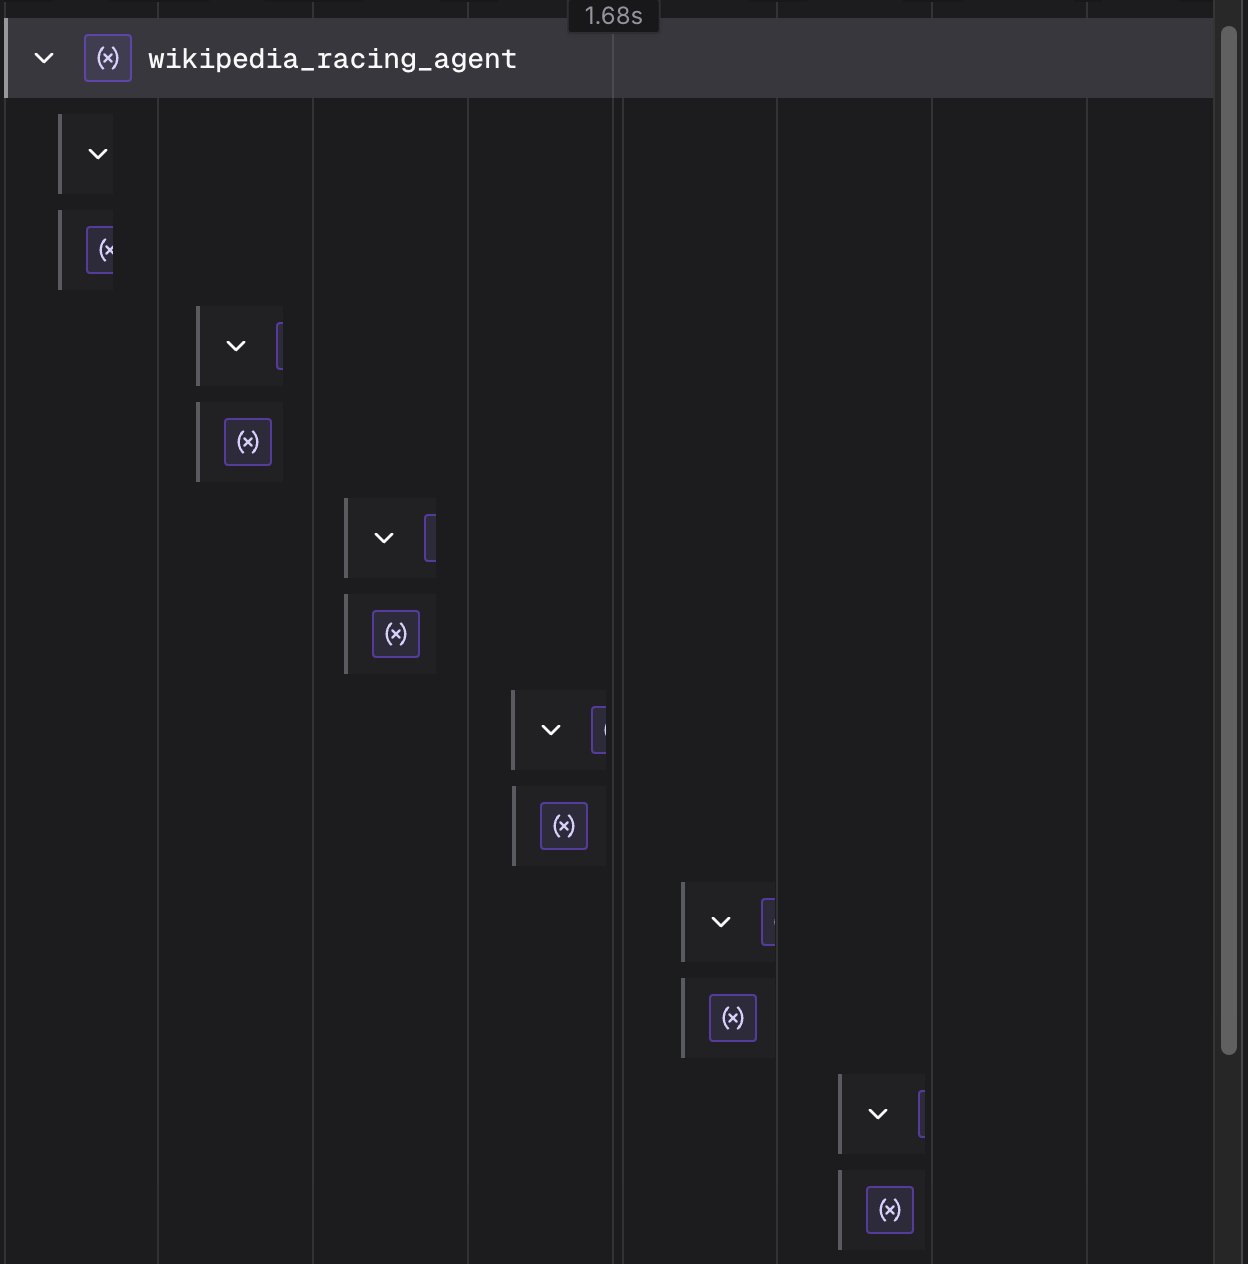

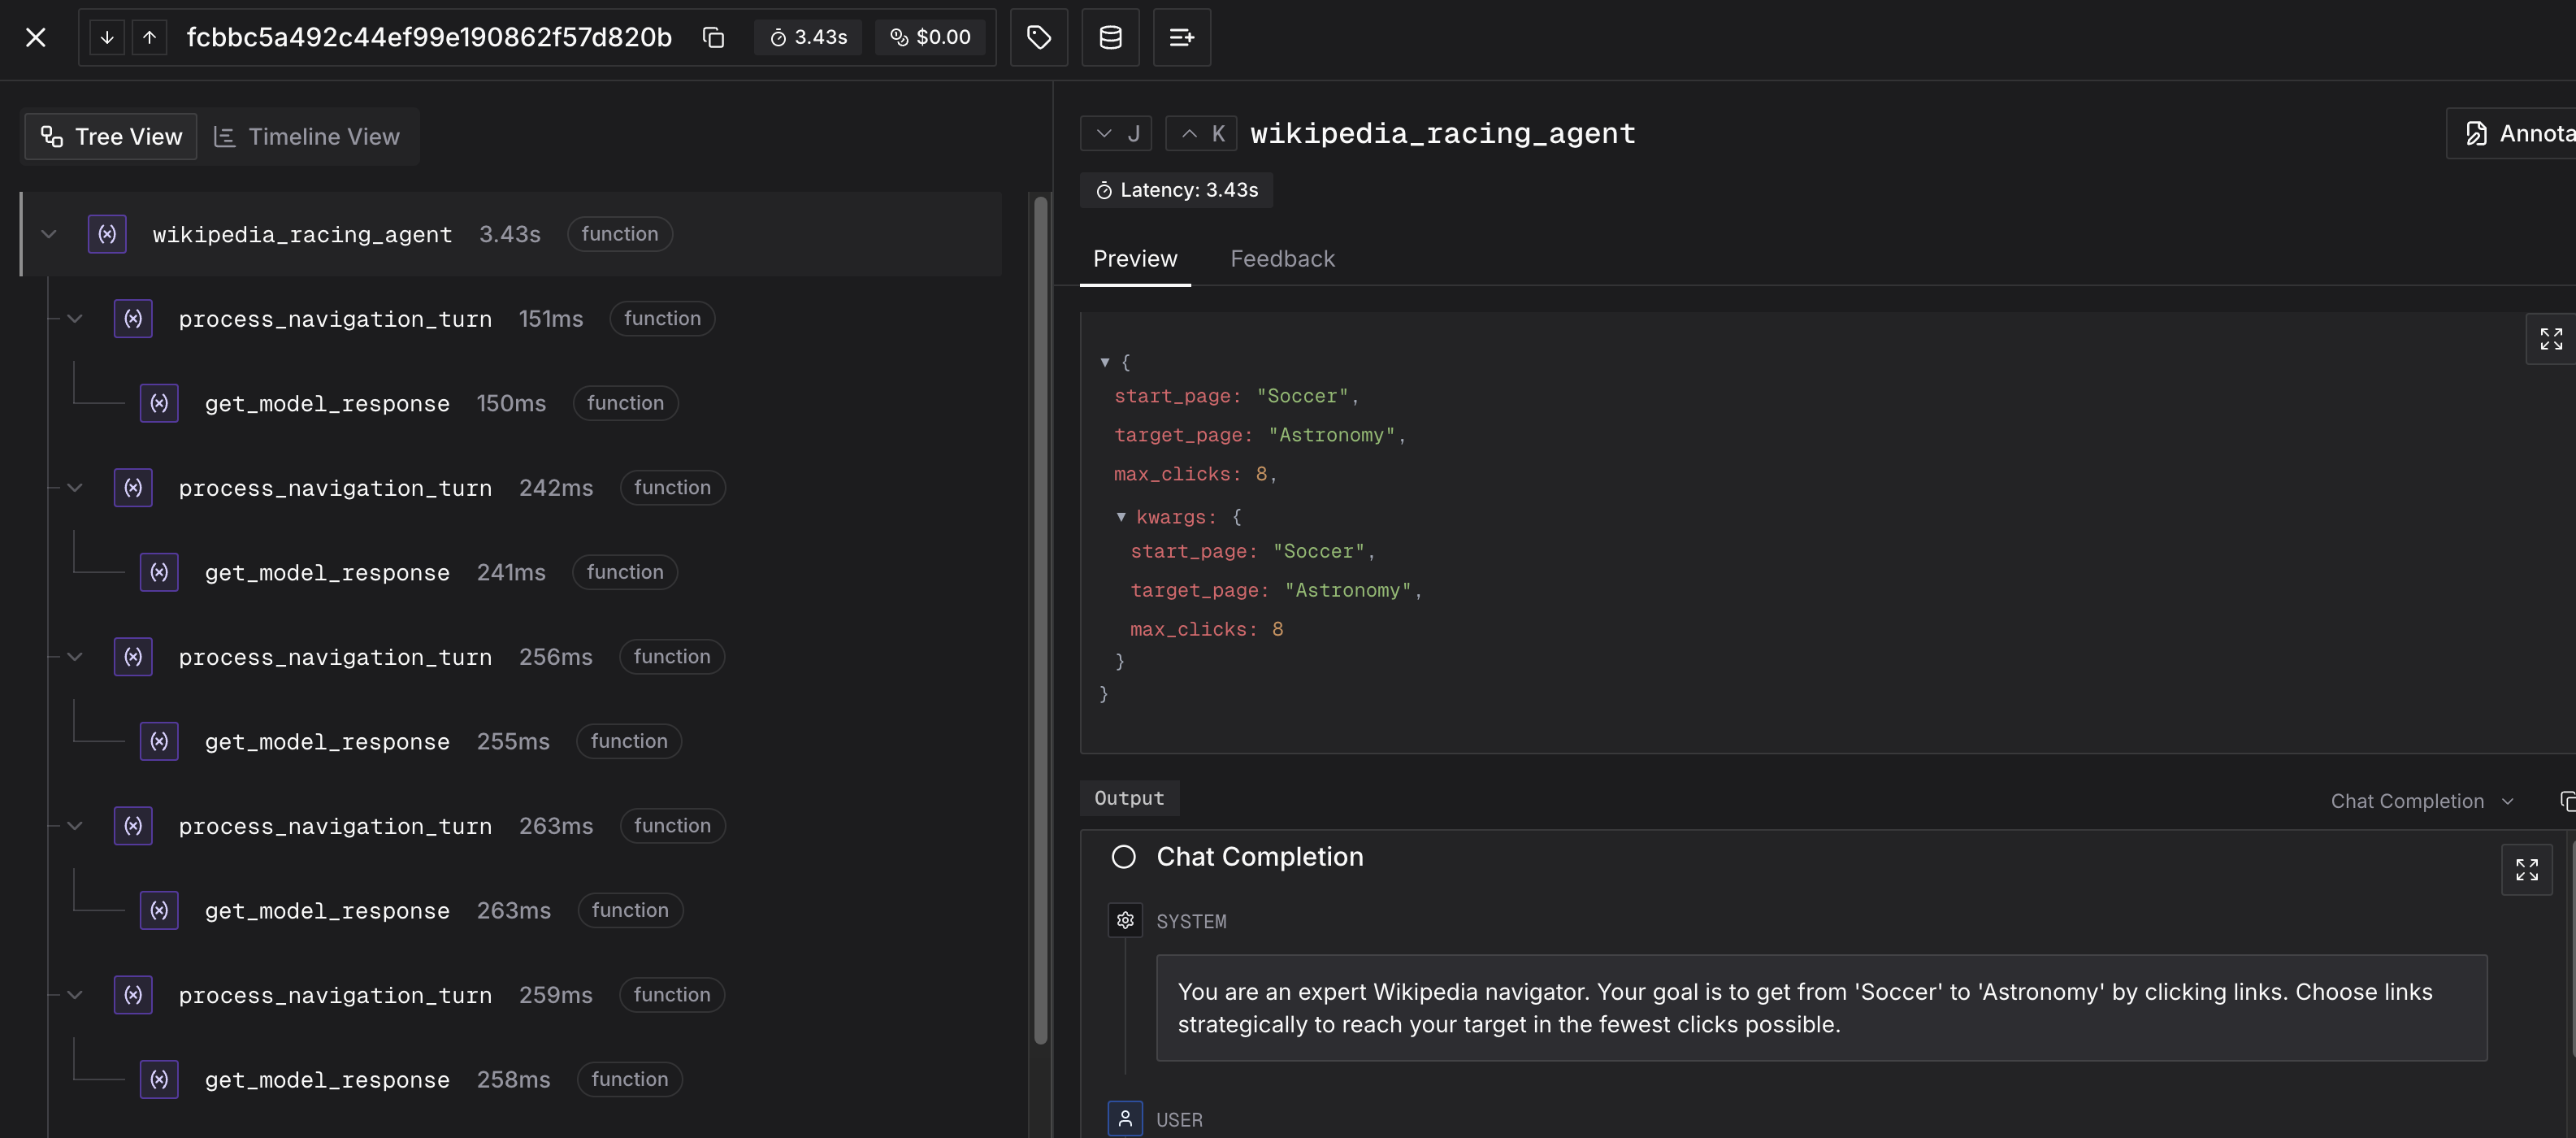



# Evaluation
Now, let's use our trained model from above to evaluate on an unseen test set. It is important to use an unseen set as the model can begin to learn patterns from the training data during training. This would invalidate accuracy metrics on data the model has already seen. Here, we use the test set we created earlier in the notebook. As we can see from the accuracy below, we now have a success rate of 62.5%

In [ ]:
# Cell: Evaluate Trained Model
"""
## Evaluating the Trained Model on Test Set

After training completes, the `model` object automatically uses the fine-tuned version
(it's now at the final training step). We'll evaluate its performance on unseen test
examples to measure how well it generalizes.
"""

print(f"✓ Model is at training step: {model.current_step}/{model.config.num_steps}")
print(f"✓ Using fine-tuned model: {model.config.model_id}-v{model.current_step}")

# Run evaluation on test set
test_results = []
for prompt in wikipedia_test_prompts:
    # Run the agent with the trained model
    result = await wikipedia_racing_agent(**prompt)

    # Score the result (returns a float between 0 and 1)
    scorer = WikipediaRacingScorer()
    score = await scorer.a_score_example(Example(input=prompt, actual_output=result))

    test_results.append({
        "prompt": prompt,
        "result": result,
        "score": score,
        "game_won": result.get("game_won", False),
        "clicks_used": result.get("clicks_used", 0)
    })

# Calculate aggregate metrics
avg_score = sum(r['score'] for r in test_results) / len(test_results)
success_rate = sum(r['game_won'] for r in test_results) / len(test_results)
avg_clicks = sum(r['clicks_used'] for r in test_results) / len(test_results)

print(f"\n{'='*50}")
print(f"Test Set Evaluation Results")
print(f"{'='*50}")
print(f"Average Score: {avg_score:.3f}")
print(f"Success Rate: {success_rate:.1%}")
print(f"Average Clicks Used: {avg_clicks:.1f}")

✓ Model is at training step: 16/5
✓ Using fine-tuned model: qwen2p5-7b-instruct-wikipedia-new-updated-v16
Agent returning: Won=True, Clicks=1, Path=2
Path: iPad → Apple Inc.
Input: {'start_page': 'iPad', 'target_page': 'Apple Inc.', 'max_clicks': 4}
Actual output type: <class 'dict'>
Actual output: {'messages': [{'role': 'system', 'content': "You are an expert Wikipedia navigator. Your goal is to get from 'iPad' to 'Apple Inc.' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."}, {'role': 'user', 'content': 'Wikipedia Racing Navigation:\n\nCurrent page: iPad\nTarget page: Apple Inc.\nClicks used: 0/4\n\nAvailable links from this page:\n- Apple Inc.\n- Apple Inc. advertising\n- Apple Inc. design motifs\n- Apple Inc. v. Pepper\n- Criticism of Apple Inc.\n- Apple I\n- Bill Campbell (business executive)\n- Bloomberg Businessweek\n- Business intelligence\n- Fast Company\n- Fast Company (magazine)\n- IOS version history\n- IPadOS version histor

See cool real-time statistics like Agent Latency so you can stay on top of your agents!

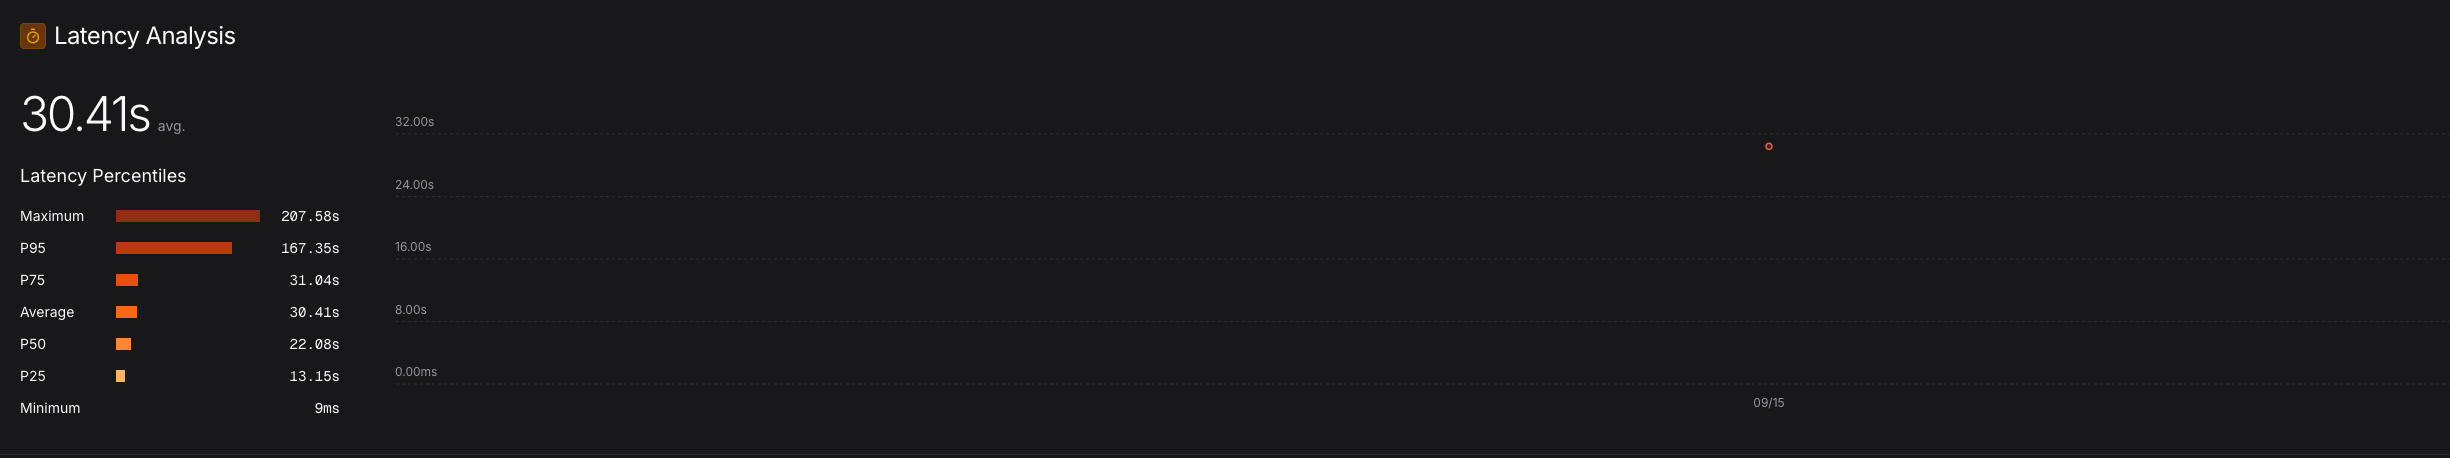

And there you go! It's that easy to create an RFT job from your existing agent code!


# Results

After some training, we can see a bit of improvement. This is when we began the RFT job. 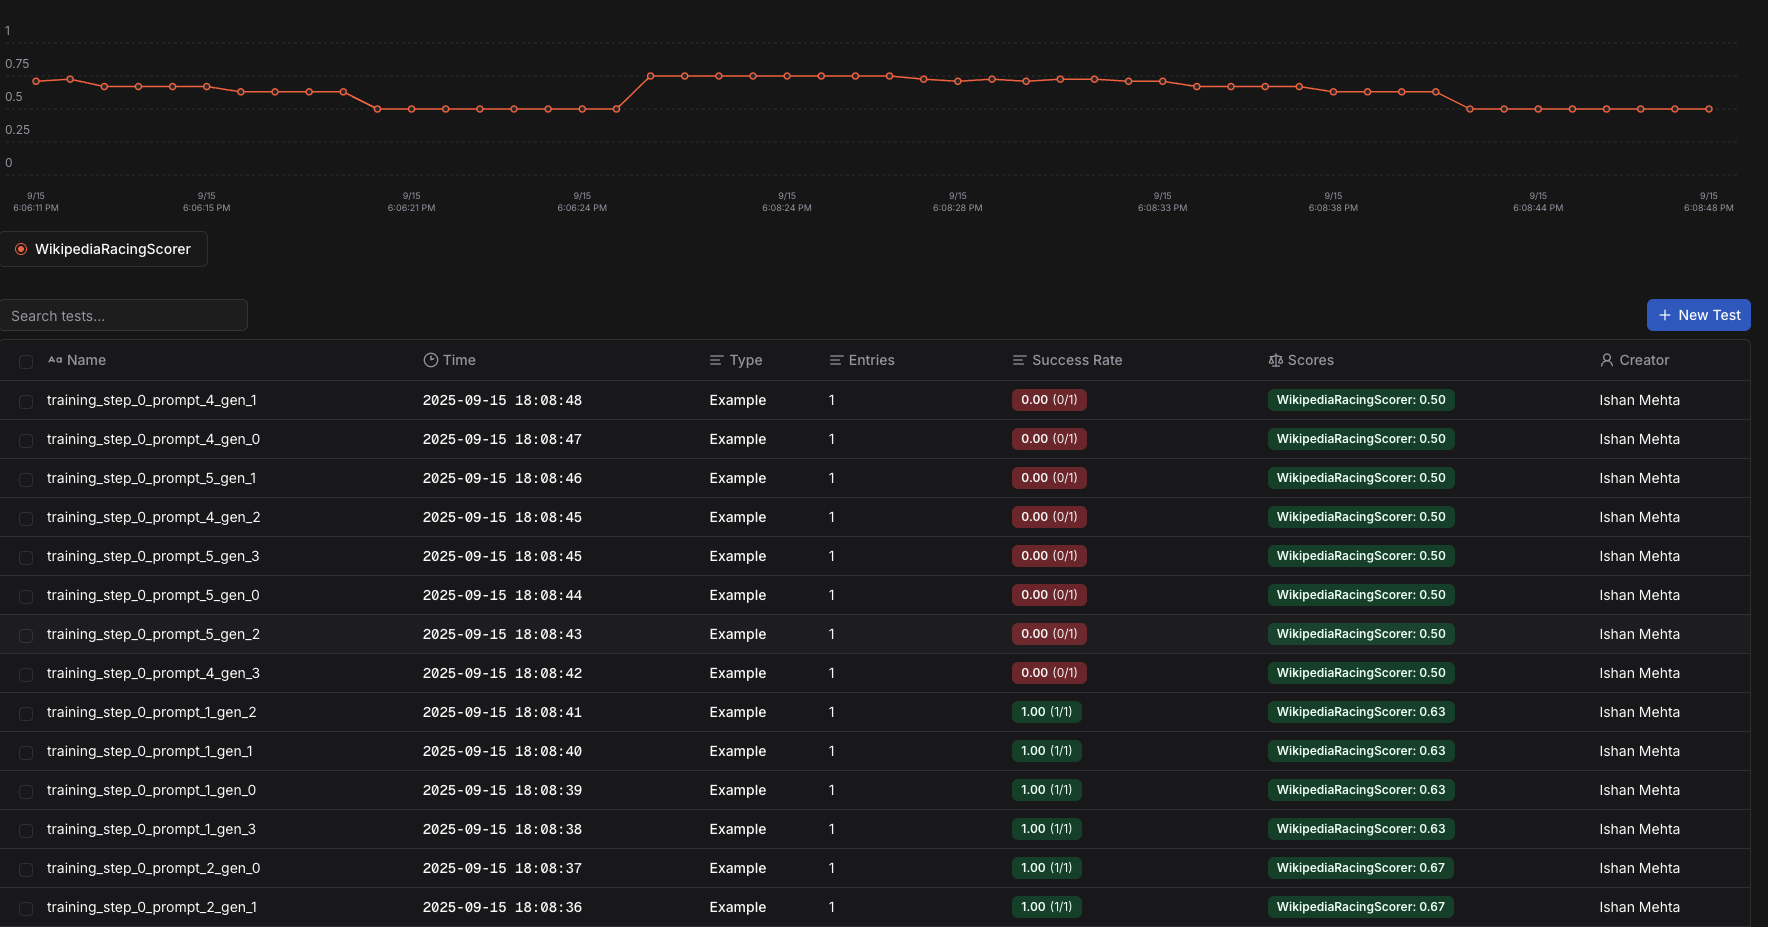

This is a bar-chart view from the Judgment UI that shows our intermediate progress. 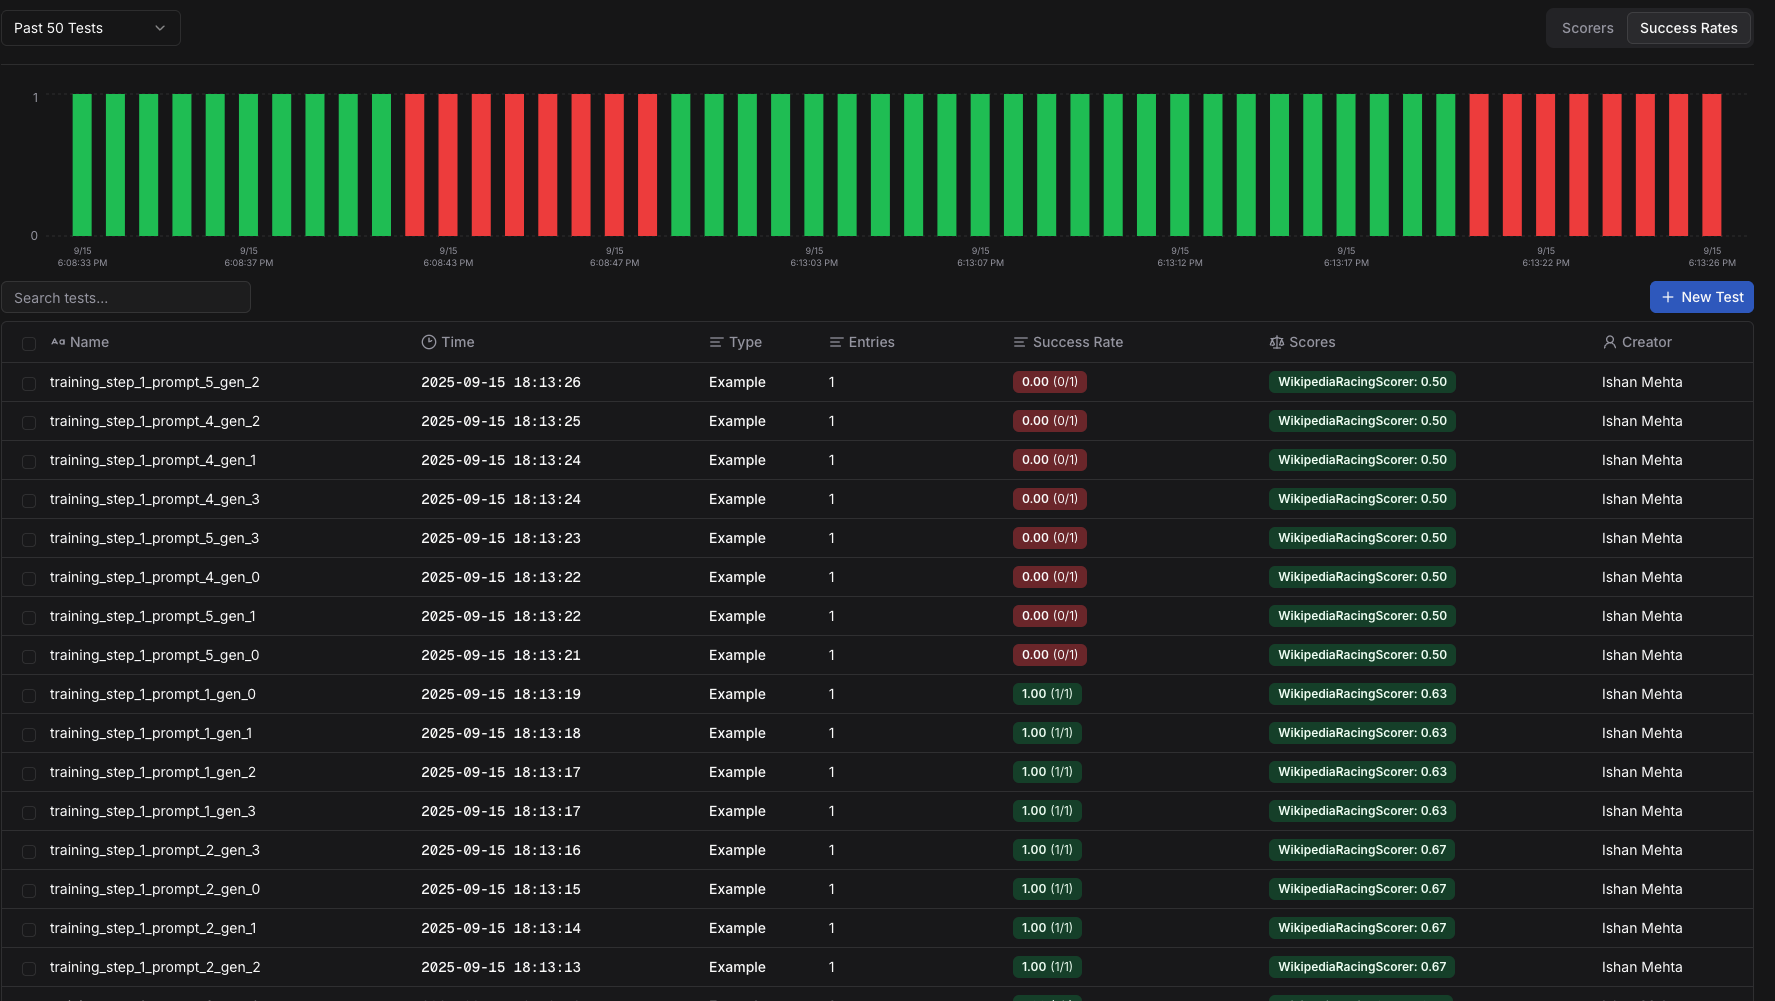

Notice some of the bars that were originally red have turned green. This shows some more progress in our RFT 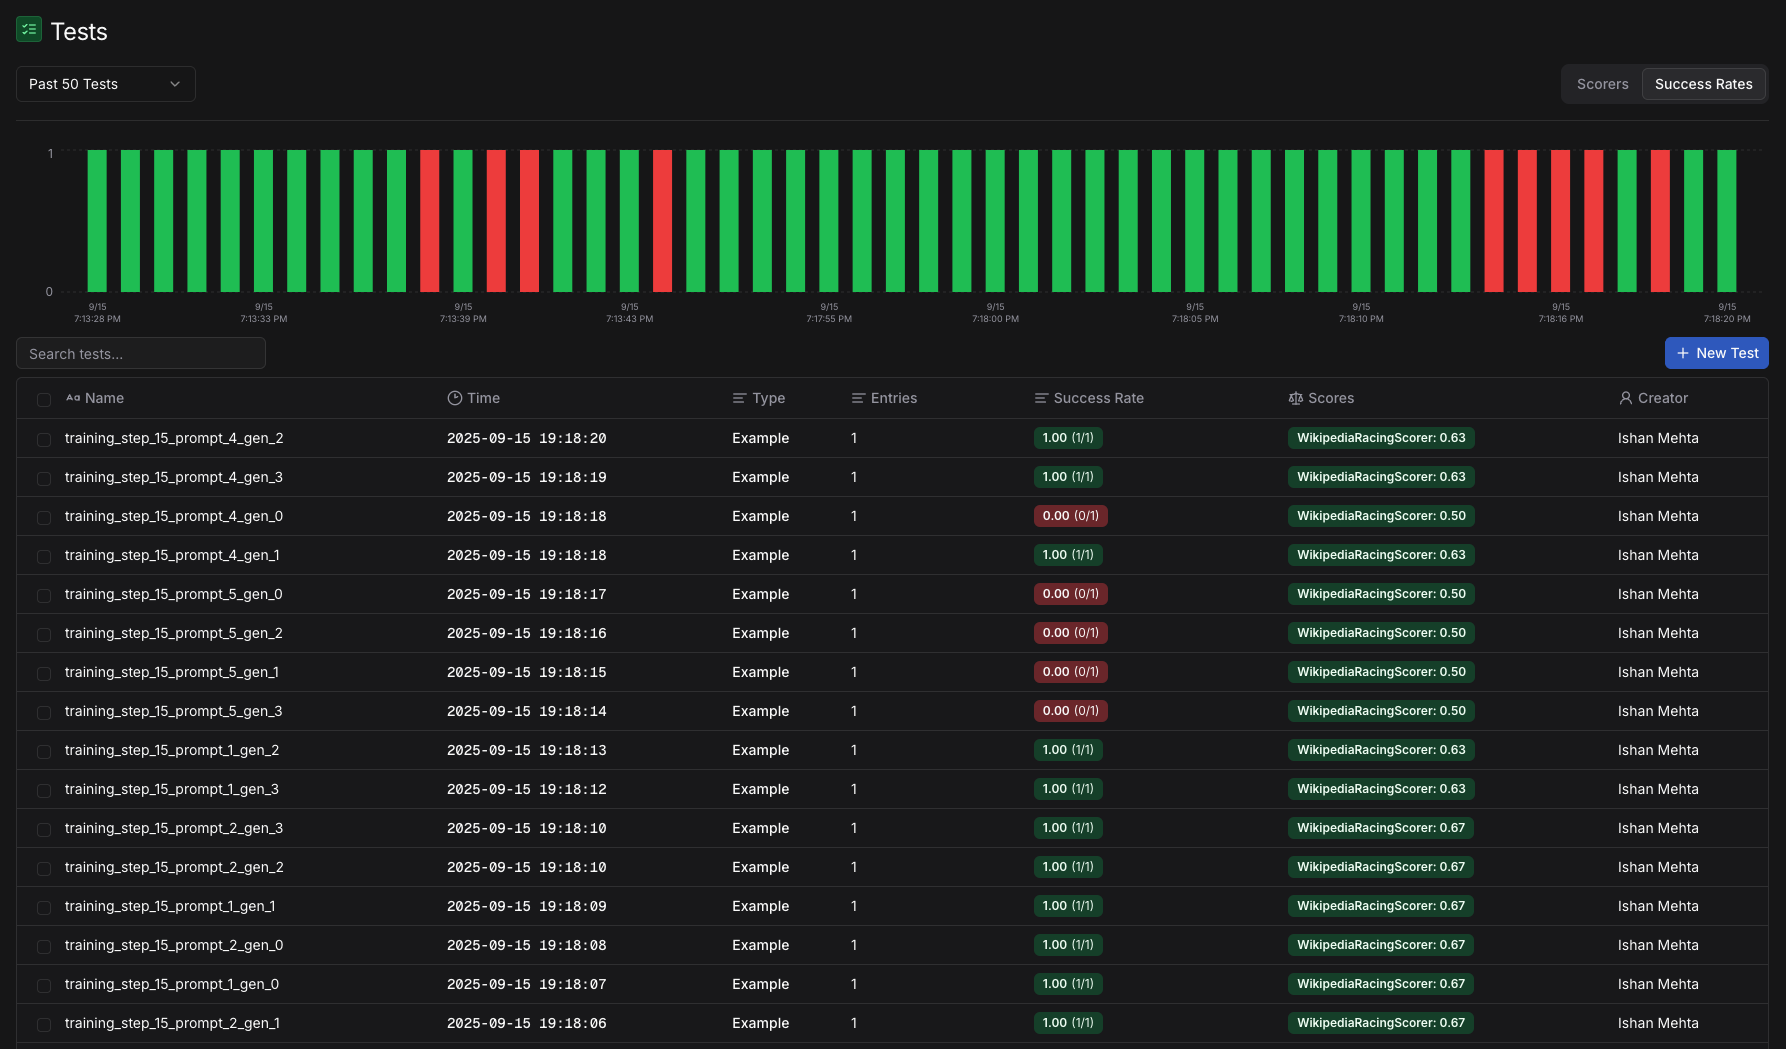

In this run, you can see the accuracy increase by almost 7% after RFT. This may seem minimal, but we only used 16 training examples which is very low for a task of this nature. This notebook is made more for demonstrative purposes so feel free to expand the training set in order to get larger RFT improvements!

# Conclusion
This brings us to the end of this notebook. To summarize, the goal of this notebook was to show the integration between Judgment Labs and the judgeval library along with Fireworks RFT. We wrote some agentic code to create a multi-turn Wikipedia racing agent, added in our own datasets, reward functions, and scorers using Judgment Lab's predefined classes, and ran a full RFT job without any of the difficult overhead!